In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import re
from datetime import datetime
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_columns', None)
pd.set_option("display.max_colwidth", None)
pd.set_option('display.max_rows', None)  # Show all rows


from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score, 
    mean_absolute_percentage_error, median_absolute_error, explained_variance_score
)

In [27]:
df = pd.read_csv('df_filtered_final.csv')

In [28]:
df = df[df['Condition']!='аварийное / не на ходу']

In [29]:
df['Brand'].value_counts()

Brand
Toyota           4520
Kia              2801
Honda            2611
Hyundai          2443
Lexus            1715
BMW              1489
Mercedes-Benz    1476
Subaru            808
Chevrolet         590
Land              270
Volkswagen        244
Geely             208
BYD               171
SsangYong         162
Audi              157
Mitsubishi        124
Mazda             110
Nissan            107
Renault            98
ВАЗ                75
Changan            66
LiXiang            63
Daewoo             59
Ford               57
Opel               46
Zeekr              39
Weltmeister        32
Tesla              30
Genesis            22
Kodiaq             20
GAC                19
Porsche            19
Skoda              19
Tank               13
Jeep               12
Suzuki             10
EXEED               8
Ravon               6
Aito                5
MG                  5
Infiniti            2
Voyah               2
Xiaomi              2
Daihatsu            1
Chery               1
Name

In [ ]:
brands_to_keep = df['Brand'].value_counts()[df['Brand'].value_counts() > 20].index
df = df[df['Brand'].isin(brands_to_keep)]


In [ ]:
len(brands_to_keep)

29

In [31]:
filtered_df.shape

(20607, 73)

In [32]:
df.head()

Views  Favorites  Year_of_manufacture  Mileage          Body_type  \
0    375          1                 2022    55000              седан   
1    674         15                 2011   250000  внедорожник 5 дв.   
2    318          2                 2019    64373  внедорожник 5 дв.   
3    709         11                 2006   280000              седан   
4    147          2                 2018   124000              седан   

         Цвет Transmission Drive_type Steering_wheel_position  Condition  \
0      черный      автомат   передний                   слева  идеальное   
1      черный     вариатор     полный                   слева  идеальное   
2       белый      автомат     полный                   слева  идеальное   
3  коричневый      автомат   передний                   слева    хорошее   
4      черный      автомат   передний                   слева  идеальное   

  Customs_clearance Region_city Registration     Exchange_option  \
0        растаможен      Бишкек   Кыргызстан  рассмотрю варианты   
1        растаможен      Бишкек   Кыргызстан  рассмотрю варианты   
2        растаможен      Бишкек   Кыргызстан  рассмотрю варианты   
3        растаможен      Бишкек   Кыргызстан  рассмотрю варианты   
4        растаможен      Бишкек   Кыргызстан  рассмотрю варианты   

  Installment_option    Brand       Model  Restyling  \
0                нет   Toyota       Camry       True   
1                нет   Toyota  Highlander       True   
2                нет      Kia    Sportage       True   
3                нет    Honda       Civic      False   
4                нет  Hyundai      Sonata       True   

       Brand_Model_Generation  Days_Ago  Upped_days Fuel_Type  Engine_Volume  \
0    Toyota Camry VIII (XV70)        24           9    бензин            3.5   
1  Toyota Highlander II (U40)        66          66    гибрид            3.5   
2             Kia Sportage IV        66          66    бензин            2.4   
3            Honda Civic VIII        66          66    бензин            1.8   
4     Hyundai Sonata VII (LF)        66          66    бензин            2.4   

           Actual_Date     Month  Season  Price_D  полный электропакет  \
0  2024-12-14 12:32:00  December  Winter    32000                    1   
1  2024-11-02 12:33:00  November  Autumn    18500                    1   
2  2024-11-02 12:33:00  November  Autumn    14200                    0   
3  2024-11-02 12:33:00  November  Autumn     4800                    0   
4  2024-11-02 12:33:00  November  Autumn    11900                    0   

   Alarm_system  Remote_start  Air_conditioner  Climate_control  \
0             1             0                1                1   
1             0             0                1                1   
2             0             0                0                0   
3             0             0                0                0   
4             1             0                1                1   

   газобалонное оборудование  круиз-контроль  Front_seat_heating  \
0                          0               0                   0   
1                          0               0                   1   
2                          0               0                   0   
3                          0               0                   0   
4                          0               0                   1   

   All_seat_heating  обогрев зеркал  Xenon_headlights  Bi_xenon_headlights  \
0                 1               0                 0                    0   
1                 0               0                 0                    0   
2                 0               0                 0                    0   
3                 0               0                 0                    0   
4                 0               0                 0                    0   

   Headlight_washer  Air_suspension  Seat_memory  Steering_wheel_memory  \
0                 0               0            0                      0   
1         

In [33]:
df.shape

(20593, 73)

In [34]:
# Get the current year
current_year = datetime.now().year

# Calculate the age of the car
df['age'] = current_year - df['Year_of_manufacture']

# Calculate the average mileage per year
df['average_mileage'] = df.apply(lambda row: row['Mileage'] / row['age'] if row['age'] > 0 else row['Year_of_manufacture'], axis=1)

condition_mapping = {
    "новое": 1,
    "идеальное": 2,
    "хорошее": 3,
    'аварийное / не на ходу':4
}

# Apply the mapping to the 'Condition' column
df['Condition_encoded'] = df['Condition'].map(condition_mapping)
df['Condition_encoded'] = df['Condition_encoded'].astype(int)

df = df[(df['Brand_Model_Generation']!='Mercedes-Benz E-Класс V (W213, S213, C238)') & (df['Price_D']!=8033)]
df = df[(df['Brand_Model_Generation']!='Daewoo Nexia I') & (df['Price_D']!=65000)]

In [35]:
df['average_mileage'].min()

0.3333333333333333

In [36]:
df['age'].max()

51

In [37]:
condition_mapping = {
    "новое": 1,
    "идеальное": 2,
    "хорошее": 3,
    'аварийное / не на ходу':4
}

# Apply the mapping to the 'Condition' column
df['Condition_encoded'] = df['Condition'].map(condition_mapping)
df['Condition_encoded'] = df['Condition_encoded'].astype(int)

# Display the first few rows to check the encoded values
print(df[['Condition', 'Condition_encoded']].head())

   Condition  Condition_encoded
0  идеальное                  2
1  идеальное                  2
2  идеальное                  2
3    хорошее                  3
4  идеальное                  2


In [38]:
df.head()

Views  Favorites  Year_of_manufacture  Mileage          Body_type  \
0    375          1                 2022    55000              седан   
1    674         15                 2011   250000  внедорожник 5 дв.   
2    318          2                 2019    64373  внедорожник 5 дв.   
3    709         11                 2006   280000              седан   
4    147          2                 2018   124000              седан   

         Цвет Transmission Drive_type Steering_wheel_position  Condition  \
0      черный      автомат   передний                   слева  идеальное   
1      черный     вариатор     полный                   слева  идеальное   
2       белый      автомат     полный                   слева  идеальное   
3  коричневый      автомат   передний                   слева    хорошее   
4      черный      автомат   передний                   слева  идеальное   

  Customs_clearance Region_city Registration     Exchange_option  \
0        растаможен      Бишкек   Кыргызстан  рассмотрю варианты   
1        растаможен      Бишкек   Кыргызстан  рассмотрю варианты   
2        растаможен      Бишкек   Кыргызстан  рассмотрю варианты   
3        растаможен      Бишкек   Кыргызстан  рассмотрю варианты   
4        растаможен      Бишкек   Кыргызстан  рассмотрю варианты   

  Installment_option    Brand       Model  Restyling  \
0                нет   Toyota       Camry       True   
1                нет   Toyota  Highlander       True   
2                нет      Kia    Sportage       True   
3                нет    Honda       Civic      False   
4                нет  Hyundai      Sonata       True   

       Brand_Model_Generation  Days_Ago  Upped_days Fuel_Type  Engine_Volume  \
0    Toyota Camry VIII (XV70)        24           9    бензин            3.5   
1  Toyota Highlander II (U40)        66          66    гибрид            3.5   
2             Kia Sportage IV        66          66    бензин            2.4   
3            Honda Civic VIII        66          66    бензин            1.8   
4     Hyundai Sonata VII (LF)        66          66    бензин            2.4   

           Actual_Date     Month  Season  Price_D  полный электропакет  \
0  2024-12-14 12:32:00  December  Winter    32000                    1   
1  2024-11-02 12:33:00  November  Autumn    18500                    1   
2  2024-11-02 12:33:00  November  Autumn    14200                    0   
3  2024-11-02 12:33:00  November  Autumn     4800                    0   
4  2024-11-02 12:33:00  November  Autumn    11900                    0   

   Alarm_system  Remote_start  Air_conditioner  Climate_control  \
0             1             0                1                1   
1             0             0                1                1   
2             0             0                0                0   
3             0             0                0                0   
4             1             0                1                1   

   газобалонное оборудование  круиз-контроль  Front_seat_heating  \
0                          0               0                   0   
1                          0               0                   1   
2                          0               0                   0   
3                          0               0                   0   
4                          0               0                   1   

   All_seat_heating  обогрев зеркал  Xenon_headlights  Bi_xenon_headlights  \
0                 1               0                 0                    0   
1                 0               0                 0                    0   
2                 0               0                 0                    0   
3                 0               0                 0                    0   
4                 0               0                 0                    0   

   Headlight_washer  Air_suspension  Seat_memory  Steering_wheel_memory  \
0                 0               0            0                      0   
1         

In [39]:
df['Steering_wheel_position'].unique()

array(['слева', 'справа'], dtype=object)

In [40]:
df['Steering_wheel_position_encoded'] = df['Steering_wheel_position'].map({'справа': 0, 'слева': 10})


In [41]:
df.head()

Views  Favorites  Year_of_manufacture  Mileage          Body_type  \
0    375          1                 2022    55000              седан   
1    674         15                 2011   250000  внедорожник 5 дв.   
2    318          2                 2019    64373  внедорожник 5 дв.   
3    709         11                 2006   280000              седан   
4    147          2                 2018   124000              седан   

         Цвет Transmission Drive_type Steering_wheel_position  Condition  \
0      черный      автомат   передний                   слева  идеальное   
1      черный     вариатор     полный                   слева  идеальное   
2       белый      автомат     полный                   слева  идеальное   
3  коричневый      автомат   передний                   слева    хорошее   
4      черный      автомат   передний                   слева  идеальное   

  Customs_clearance Region_city Registration     Exchange_option  \
0        растаможен      Бишкек   Кыргызстан  рассмотрю варианты   
1        растаможен      Бишкек   Кыргызстан  рассмотрю варианты   
2        растаможен      Бишкек   Кыргызстан  рассмотрю варианты   
3        растаможен      Бишкек   Кыргызстан  рассмотрю варианты   
4        растаможен      Бишкек   Кыргызстан  рассмотрю варианты   

  Installment_option    Brand       Model  Restyling  \
0                нет   Toyota       Camry       True   
1                нет   Toyota  Highlander       True   
2                нет      Kia    Sportage       True   
3                нет    Honda       Civic      False   
4                нет  Hyundai      Sonata       True   

       Brand_Model_Generation  Days_Ago  Upped_days Fuel_Type  Engine_Volume  \
0    Toyota Camry VIII (XV70)        24           9    бензин            3.5   
1  Toyota Highlander II (U40)        66          66    гибрид            3.5   
2             Kia Sportage IV        66          66    бензин            2.4   
3            Honda Civic VIII        66          66    бензин            1.8   
4     Hyundai Sonata VII (LF)        66          66    бензин            2.4   

           Actual_Date     Month  Season  Price_D  полный электропакет  \
0  2024-12-14 12:32:00  December  Winter    32000                    1   
1  2024-11-02 12:33:00  November  Autumn    18500                    1   
2  2024-11-02 12:33:00  November  Autumn    14200                    0   
3  2024-11-02 12:33:00  November  Autumn     4800                    0   
4  2024-11-02 12:33:00  November  Autumn    11900                    0   

   Alarm_system  Remote_start  Air_conditioner  Climate_control  \
0             1             0                1                1   
1             0             0                1                1   
2             0             0                0                0   
3             0             0                0                0   
4             1             0                1                1   

   газобалонное оборудование  круиз-контроль  Front_seat_heating  \
0                          0               0                   0   
1                          0               0                   1   
2                          0               0                   0   
3                          0               0                   0   
4                          0               0                   1   

   All_seat_heating  обогрев зеркал  Xenon_headlights  Bi_xenon_headlights  \
0                 1               0                 0                    0   
1                 0               0                 0                    0   
2                 0               0                 0                    0   
3                 0               0                 0                    0   
4                 0               0                 0                    0   

   Headlight_washer  Air_suspension  Seat_memory  Steering_wheel_memory  \
0                 0               0            0                      0   
1         

In [42]:
df = df[(df['Brand_Model_Generation']!='Mercedes-Benz E-Класс V (W213, S213, C238)') & (df['Price_D']!=8033)]
df = df[(df['Brand_Model_Generation']!='Daewoo Nexia I') & (df['Price_D']!=65000)]

0:	learn: 14332.3663046	test: 14267.5621463	best: 14267.5621463 (0)	total: 240ms	remaining: 3m 59s
100:	learn: 3736.9920617	test: 4504.5089527	best: 4504.5089527 (100)	total: 8.79s	remaining: 1m 18s
200:	learn: 3007.3392606	test: 4174.0291632	best: 4174.0291632 (200)	total: 17.4s	remaining: 1m 9s
300:	learn: 2612.3308436	test: 4097.6748538	best: 4097.6748538 (300)	total: 26.1s	remaining: 1m
400:	learn: 2311.1190679	test: 4055.8420083	best: 4055.2243775 (398)	total: 35s	remaining: 52.3s
500:	learn: 2098.5411860	test: 4039.7402852	best: 4038.8197059 (498)	total: 44s	remaining: 43.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 4033.521579
bestIteration = 530

Shrink model to first 531 iterations.
Mean Absolute Error (MAE): 2078.39
Root Mean Squared Error (RMSE): 4033.52
R² Score: 0.9348
Mean Absolute Percentage Error (MAPE): 11.29%
Median Absolute Error: 1116.95
Explained Variance Score: 0.9348


C:\Users\Burmachach.Nuradilov\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


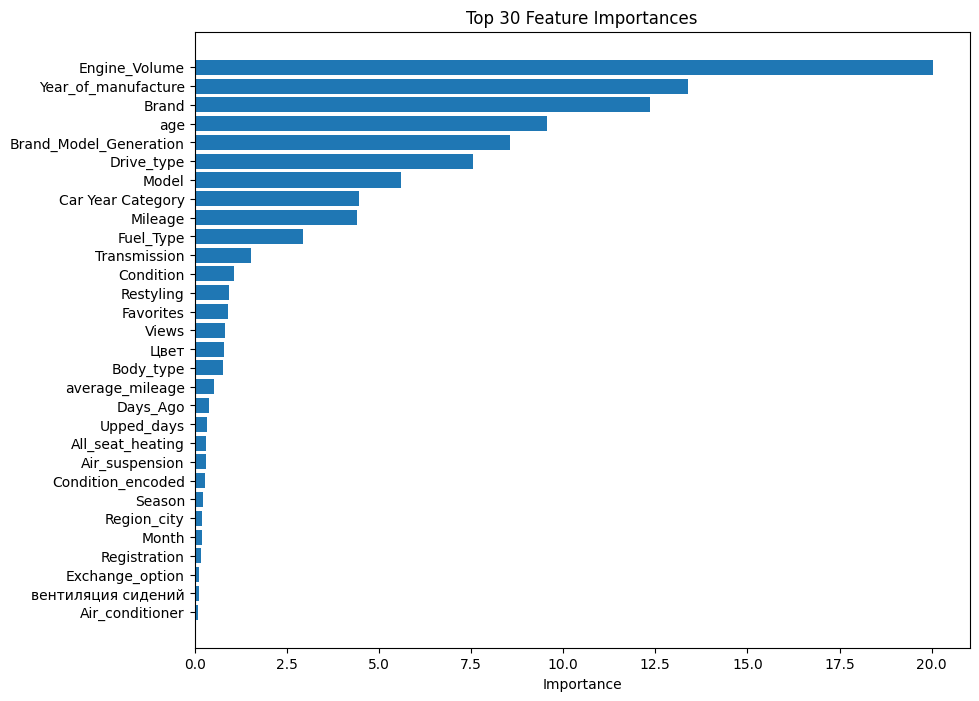

In [20]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score, 
    mean_absolute_percentage_error, median_absolute_error, explained_variance_score
)


X = df.drop(columns=['Price_D'])  # Features
y = df['Price_D']  # Target

# Identify categorical columns by their indices
categorical_columns = [
    X.columns.get_loc(col) 
    for col in X.select_dtypes(include=['object', 'category']).columns
]

# Step 2: Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Step 3: Initialize and train CatBoost with categorical features
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.13673617656361287,
    depth=8,
    l2_leaf_reg=2.3358152187917005,
    bagging_temperature=0.7944641961311574,
    cat_features=categorical_columns,
    random_seed=42,
    verbose=100
)

model.fit(
    X_train, 
    y_train, 
    eval_set=(X_test, y_test), 
    use_best_model=True,
    early_stopping_rounds=50
)

# Step 4: Evaluate the model
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # Convert to percentage
median_ae = median_absolute_error(y_test, y_pred)
explained_var = explained_variance_score(y_test, y_pred)

# Display the results
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Median Absolute Error: {median_ae:.2f}")
print(f"Explained Variance Score: {explained_var:.4f}")

# Feature Importance Visualization
feature_importances = model.get_feature_importance()
feature_names = X.columns

feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(feat_imp_df['Feature'][:30][::-1], feat_imp_df['Importance'][:30][::-1])
plt.xlabel('Importance')
plt.title('Top 30 Feature Importances')
plt.show()

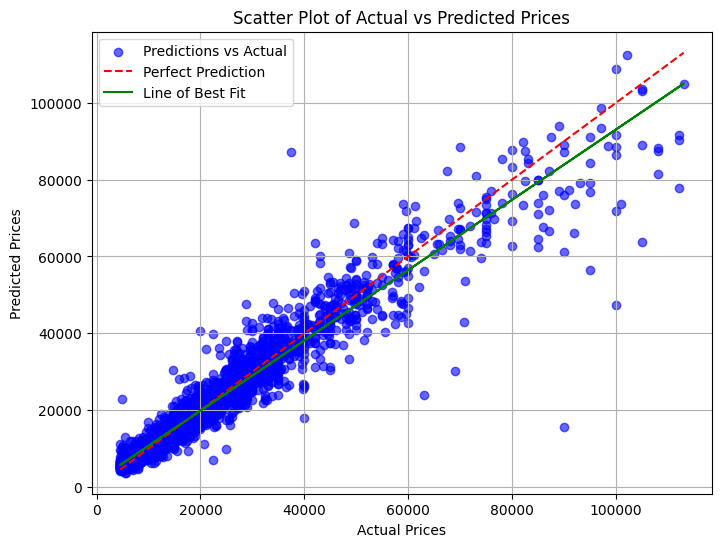

In [21]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 6))

# Scatter plot: Actual vs Predicted
plt.scatter(y_test, y_pred, alpha=0.6, label='Predictions vs Actual', color='blue')

# Add a reference line for perfect predictions
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')

# Add a line of best fit (regression line)
slope, intercept = np.polyfit(y_test, y_pred, 1)
plt.plot(y_test, slope * y_test + intercept, color='green', label='Line of Best Fit')

# Customize the plot
plt.title('Scatter Plot of Actual vs Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [22]:
comparison_df = pd.DataFrame({
    'Actual Prices': y_test,
    'Predicted Prices': y_pred
})

# Print the DataFrame to see the comparison
print(comparison_df)

       Actual Prices  Predicted Prices
17219          18500      20401.289608
10023          23000      18749.998027
17963           7807       8263.515120
8370            8800       8820.226069
15973          29900      37623.850159
7815           27000      29787.889300
10990           7115       6167.572779
971             9200       9557.495406
7401            6312       5975.618030
8283            6900       7144.378895
2945           11500      13503.382323
6029           37000      36934.669922
1628            7115       8384.667412
13409          35000      23826.469204
9061           17600      18481.344436
16725          32500      33836.426346
2651            5967       7380.367556
15542          48500      44012.292067
16128          30000      25778.805720
19062          26000      25655.144058
7891            7500       8099.701189
3524           17500      11904.446787
11578           6000       7391.746041
1471           11600      12598.068406
10103          16600     

In [23]:
df_results = pd.DataFrame({
    'Цена': y_test,
    'Predicted_Price': y_pred
})

# Ensure the DataFrame is sorted or indexed correctly
df_results.reset_index(drop=True, inplace=True)
bins = [4500, 4800, 5000, 8000, 10000, 15000, 20000, 40000, 60000, 67000, 90000]
labels = ['4.5-4.8k','4.8-5k', '5-8k', '8-10k','10-15k','15k-20k', '20k-40k', '40k-60k', '60k-80k', '80k-90k']


# Create custom bins using pd.cut
df_results['Price_Bin'] = pd.cut(df_results['Цена'], bins=bins, labels=labels, right=False)
def calculate_errors(group):
    mae = np.mean(np.abs(group['Цена'] - group['Predicted_Price']))
    rmse = np.sqrt(np.mean((group['Цена'] - group['Predicted_Price'])**2))
    mape = np.mean(np.abs((group['Цена'] - group['Predicted_Price']) / group['Цена'])) * 100
    return pd.Series({'MAE': mae, 'RMSE': rmse, 'MAPE': mape})

# Apply the function to each bin
error_metrics = df_results.groupby('Price_Bin').apply(calculate_errors).reset_index()

error_metrics

C:\Users\Burmachach.Nuradilov\AppData\Local\Temp\ipykernel_26856\862564720.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_metrics = df_results.groupby('Price_Bin').apply(calculate_errors).reset_index()
C:\Users\Burmachach.Nuradilov\AppData\Local\Temp\ipykernel_26856\862564720.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  error_metrics = df_results.groupby('Price_Bin').apply(calculate_errors).reset_index()


Price_Bin          MAE          RMSE       MAPE
0  4.5-4.8k  1433.810137   1914.477063  31.060553
1    4.8-5k  1360.921784   2877.965050  28.012105
2      5-8k   838.068504   1181.691277  13.373421
3     8-10k   949.413024   1238.845099  10.712267
4    10-15k  1164.917345   1632.722364   9.438697
5   15k-20k  1630.136837   2226.593484   9.492998
6   20k-40k  3038.469005   4479.142299  10.876863
7   40k-60k  5070.736951   6655.277234  10.522010
8   60k-80k  6648.679921  10276.359932  10.760352
9   80k-90k  8295.655099  10925.409766  10.782328

In [24]:
y_train_log = np.log1p(y_train)  # Log transformation (log(x+1))
y_test_log = np.log1p(y_test)

# Train the model using the transformed target
model.fit(X_train, y_train_log, eval_set=(X_test, y_test_log), use_best_model=True, early_stopping_rounds=50)

# Reverse the log transformation after prediction
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log) 

0:	learn: 0.6076950	test: 0.6032252	best: 0.6032252 (0)	total: 78.2ms	remaining: 1m 18s
100:	learn: 0.1433743	test: 0.1571193	best: 0.1571193 (100)	total: 9.06s	remaining: 1m 20s
200:	learn: 0.1223847	test: 0.1484740	best: 0.1484740 (200)	total: 17.6s	remaining: 1m 10s
300:	learn: 0.1092721	test: 0.1449951	best: 0.1449951 (300)	total: 26.4s	remaining: 1m 1s
400:	learn: 0.1005739	test: 0.1440583	best: 0.1440540 (399)	total: 35.1s	remaining: 52.4s
500:	learn: 0.0926823	test: 0.1430598	best: 0.1430598 (500)	total: 43.8s	remaining: 43.6s
600:	learn: 0.0862485	test: 0.1424047	best: 0.1424047 (600)	total: 52.6s	remaining: 34.9s
700:	learn: 0.0810541	test: 0.1421632	best: 0.1421632 (700)	total: 1m 1s	remaining: 26.2s
800:	learn: 0.0760885	test: 0.1418058	best: 0.1417702 (783)	total: 1m 10s	remaining: 17.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1417183597
bestIteration = 818

Shrink model to first 819 iterations.


In [25]:
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # Convert to percentage
median_ae = median_absolute_error(y_test, y_pred)
explained_var = explained_variance_score(y_test, y_pred)

# Display the results
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Median Absolute Error: {median_ae:.2f}")
print(f"Explained Variance Score: {explained_var:.4f}")


Mean Absolute Error (MAE): 1977.95
Root Mean Squared Error (RMSE): 4097.07
R² Score: 0.9327
Mean Absolute Percentage Error (MAPE): 9.90%
Median Absolute Error: 967.79
Explained Variance Score: 0.9330


C:\Users\Burmachach.Nuradilov\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [76]:
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # Convert to percentage
median_ae = median_absolute_error(y_test, y_pred)
explained_var = explained_variance_score(y_test, y_pred)

# Display the results
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Median Absolute Error: {median_ae:.2f}")
print(f"Explained Variance Score: {explained_var:.4f}")


Mean Absolute Error (MAE): 1973.92
Root Mean Squared Error (RMSE): 4004.96
R² Score: 0.9391
Mean Absolute Percentage Error (MAPE): 9.60%
Median Absolute Error: 903.83
Explained Variance Score: 0.9396


C:\Users\Burmachach.Nuradilov\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


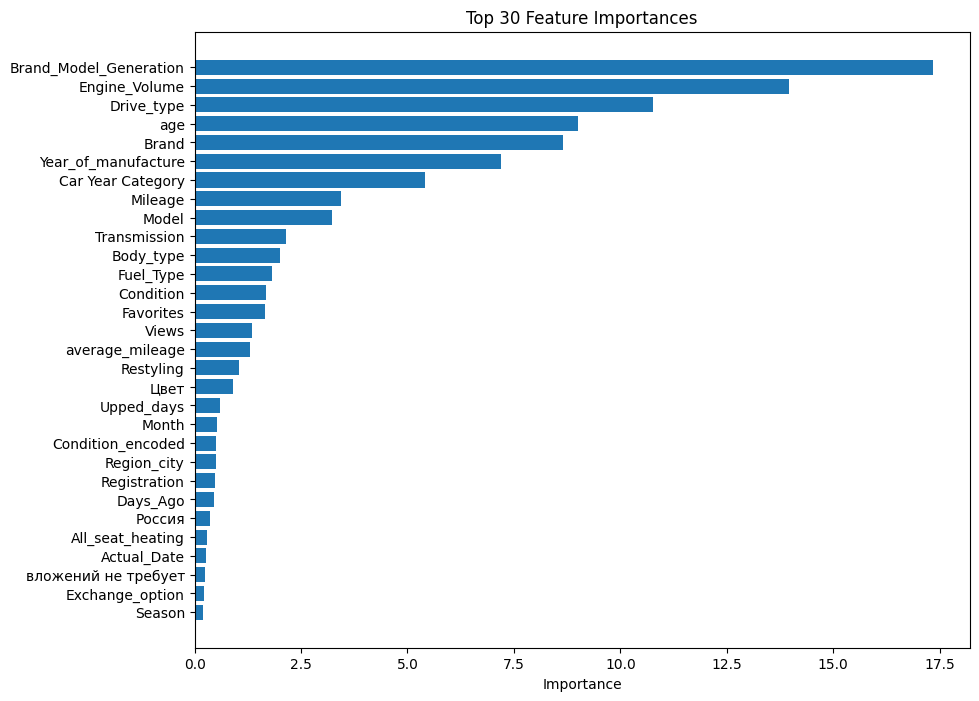

In [26]:
feature_importances = model.get_feature_importance()
feature_names = X.columns

feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(feat_imp_df['Feature'][:30][::-1], feat_imp_df['Importance'][:30][::-1])
plt.xlabel('Importance')
plt.title('Top 30 Feature Importances')
plt.show()

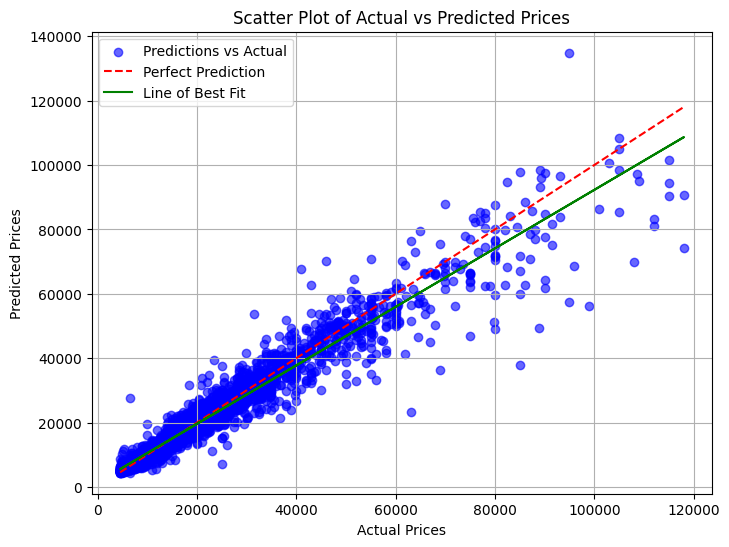

In [77]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 6))

# Scatter plot: Actual vs Predicted
plt.scatter(y_test, y_pred, alpha=0.6, label='Predictions vs Actual', color='blue')

# Add a reference line for perfect predictions
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')

# Add a line of best fit (regression line)
slope, intercept = np.polyfit(y_test, y_pred, 1)
plt.plot(y_test, slope * y_test + intercept, color='green', label='Line of Best Fit')

# Customize the plot
plt.title('Scatter Plot of Actual vs Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

0:	learn: 0.6083610	test: 0.6071631	best: 0.6071631 (0)	total: 76.3ms	remaining: 1m 16s
100:	learn: 0.1417459	test: 0.1580182	best: 0.1580182 (100)	total: 10s	remaining: 1m 29s
200:	learn: 0.1197389	test: 0.1491951	best: 0.1491851 (199)	total: 20.2s	remaining: 1m 20s
300:	learn: 0.1073215	test: 0.1457785	best: 0.1457770 (299)	total: 30.4s	remaining: 1m 10s
400:	learn: 0.0982864	test: 0.1438569	best: 0.1438352 (398)	total: 41.7s	remaining: 1m 2s
500:	learn: 0.0908443	test: 0.1426661	best: 0.1426601 (499)	total: 53.1s	remaining: 52.9s
600:	learn: 0.0848334	test: 0.1423501	best: 0.1423403 (595)	total: 1m 4s	remaining: 42.6s
700:	learn: 0.0792605	test: 0.1418156	best: 0.1417758 (691)	total: 1m 15s	remaining: 32s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1417758207
bestIteration = 691

Shrink model to first 692 iterations.
Mean Absolute Error (MAE): 2033.70
Root Mean Squared Error (RMSE): 4274.07
R² Score: 0.9280
Mean Absolute Percentage Error (MAPE): 9.81%
Median 

C:\Users\Burmachach.Nuradilov\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


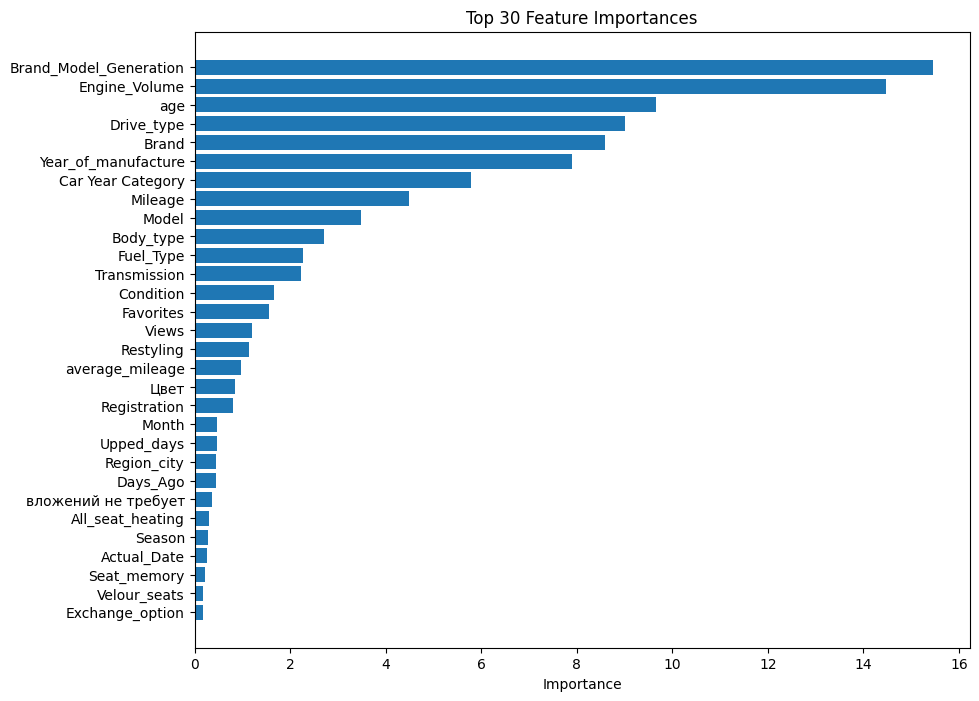

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score, 
    mean_absolute_percentage_error, median_absolute_error, explained_variance_score
)

# Prepare the features and target
X = df.drop(columns=['Price_D'])  # Features
y = df['Price_D']  # Target

# Apply log transformation to the target variable
y_log = np.log1p(y)  # Log transformation (log(x + 1))

# Identify categorical columns by their indices
categorical_columns = [
    X.columns.get_loc(col) 
    for col in X.select_dtypes(include=['object', 'category']).columns
]

# Step 2: Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42  # Use y_log for training
)

# Step 3: Initialize and train CatBoost with categorical features
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.13673617656361287,
    depth=8,
    l2_leaf_reg=2.3358152187917005,
    bagging_temperature=0.7944641961311574,
    cat_features=categorical_columns,
    random_seed=42,
    verbose=100
)

model.fit(
    X_train, 
    y_train, 
    eval_set=(X_test, y_test), 
    use_best_model=True,
    early_stopping_rounds=50
)

# Step 4: Evaluate the model
y_pred_log = model.predict(X_test)

# Reverse the log transformation after prediction
y_pred = np.expm1(y_pred_log)  # Reverse log(x + 1) transformation

# Calculate evaluation metrics
mae = mean_absolute_error(np.expm1(y_test), y_pred)  # Reverse the log transformation for y_test
rmse = mean_squared_error(np.expm1(y_test), y_pred, squared=False)
r2 = r2_score(np.expm1(y_test), y_pred)
mape = mean_absolute_percentage_error(np.expm1(y_test), y_pred) * 100  # Convert to percentage
median_ae = median_absolute_error(np.expm1(y_test), y_pred)
explained_var = explained_variance_score(np.expm1(y_test), y_pred)

# Display the results
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Median Absolute Error: {median_ae:.2f}")
print(f"Explained Variance Score: {explained_var:.4f}")

# Feature Importance Visualization
feature_importances = model.get_feature_importance()
feature_names = X.columns

feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(feat_imp_df['Feature'][:30][::-1], feat_imp_df['Importance'][:30][::-1])
plt.xlabel('Importance')
plt.title('Top 30 Feature Importances')
plt.show()


In [28]:
df_results = pd.DataFrame({
    'Цена': y_test,
    'Predicted_Price': y_pred
})

# Ensure the DataFrame is sorted or indexed correctly
df_results.reset_index(drop=True, inplace=True)
bins = [4500, 4800, 5000, 8000, 10000, 15000, 20000, 40000, 60000, 67000, 90000]
labels = ['4.5-4.8k','4.8-5k', '5-8k', '8-10k','10-15k','15k-20k', '20k-40k', '40k-60k', '60k-80k', '80k-90k']


# Create custom bins using pd.cut
df_results['Price_Bin'] = pd.cut(df_results['Цена'], bins=bins, labels=labels, right=False)
def calculate_errors(group):
    mae = np.mean(np.abs(group['Цена'] - group['Predicted_Price']))
    rmse = np.sqrt(np.mean((group['Цена'] - group['Predicted_Price'])**2))
    mape = np.mean(np.abs((group['Цена'] - group['Predicted_Price']) / group['Цена'])) * 100
    return pd.Series({'MAE': mae, 'RMSE': rmse, 'MAPE': mape})

# Apply the function to each bin
error_metrics = df_results.groupby('Price_Bin').apply(calculate_errors).reset_index()

error_metrics

C:\Users\Burmachach.Nuradilov\AppData\Local\Temp\ipykernel_17500\862564720.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_metrics = df_results.groupby('Price_Bin').apply(calculate_errors).reset_index()
C:\Users\Burmachach.Nuradilov\AppData\Local\Temp\ipykernel_17500\862564720.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  error_metrics = df_results.groupby('Price_Bin').apply(calculate_errors).reset_index()


Price_Bin  MAE  RMSE  MAPE
0  4.5-4.8k  NaN   NaN   NaN
1    4.8-5k  NaN   NaN   NaN
2      5-8k  NaN   NaN   NaN
3     8-10k  NaN   NaN   NaN
4    10-15k  NaN   NaN   NaN
5   15k-20k  NaN   NaN   NaN
6   20k-40k  NaN   NaN   NaN
7   40k-60k  NaN   NaN   NaN
8   60k-80k  NaN   NaN   NaN
9   80k-90k  NaN   NaN   NaN

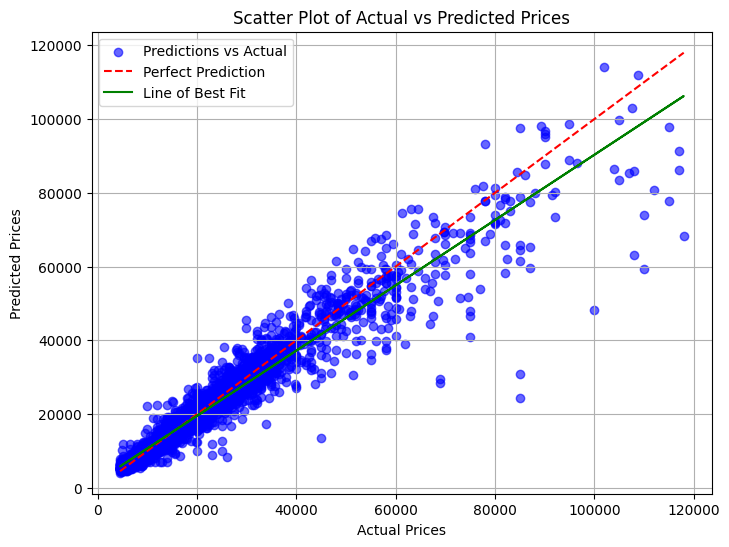

In [29]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 6))

# Scatter plot: Actual vs Predicted
plt.scatter(np.expm1(y_test), y_pred, alpha=0.6, label='Predictions vs Actual', color='blue')

# Add a reference line for perfect predictions
plt.plot([min(np.expm1(y_test)), max(np.expm1(y_test))], [min(np.expm1(y_test)), max(np.expm1(y_test))], color='red', linestyle='--', label='Perfect Prediction')

# Add a line of best fit (regression line)
slope, intercept = np.polyfit(np.expm1(y_test), y_pred, 1)
plt.plot(np.expm1(y_test), slope * np.expm1(y_test) + intercept, color='green', label='Line of Best Fit')

# Customize the plot
plt.title('Scatter Plot of Actual vs Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

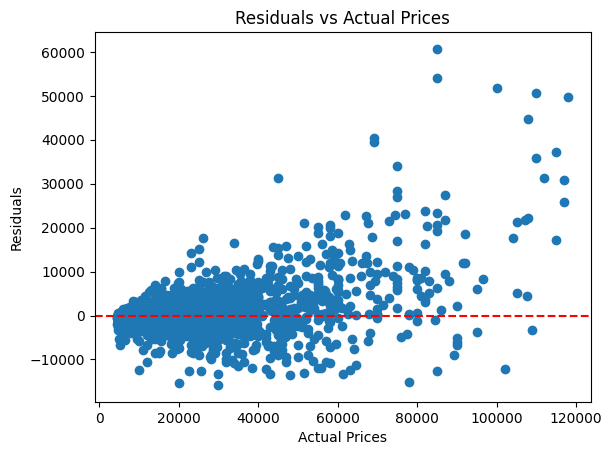

In [30]:
residuals = np.expm1(y_test) - y_pred
plt.scatter(np.expm1(y_test), residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Actual Prices")
plt.xlabel("Actual Prices")
plt.ylabel("Residuals")
plt.show()

In [89]:
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Assuming you already have the data loaded in `df` and 'Price_D' as the target column
X = df.drop(columns=['Price_D'])
y = df['Price_D']

# Identify categorical columns in the feature set
categorical_columns = X.select_dtypes(include=['object', 'category']).columns

# Label encoding for XGBoost (XGBoost does not handle categorical variables natively)
encoder = LabelEncoder()

# Apply label encoding to categorical columns for XGBoost
for col in categorical_columns:
    X[col] = encoder.fit_transform(X[col].astype(str))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the CatBoost and XGBoost models
catboost_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    cat_features=list(categorical_columns),  # Pass categorical column names directly to CatBoost
    random_seed=42,
    verbose=100
)

xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.1, max_depth=6, random_state=42)

# Define stacking model with CatBoost and XGBoost as base learners
estimators = [
    ('catboost', catboost_model),
    ('xgboost', xgb_model)
]

stacking_model = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())

# Fit the stacking model on the training data
stacking_model.fit(X_train, y_train)

# Make predictions
y_pred = stacking_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")


0:	learn: 14732.8011341	total: 47ms	remaining: 47s
100:	learn: 4634.9224230	total: 4.38s	remaining: 39s
200:	learn: 4071.0471795	total: 8.87s	remaining: 35.3s
300:	learn: 3729.9531524	total: 13.4s	remaining: 31.2s
400:	learn: 3469.7879910	total: 17.9s	remaining: 26.8s
500:	learn: 3278.0396453	total: 22.4s	remaining: 22.3s
600:	learn: 3125.8646132	total: 26.8s	remaining: 17.8s
700:	learn: 3000.0146298	total: 31.3s	remaining: 13.4s
800:	learn: 2880.1734730	total: 35.9s	remaining: 8.91s
900:	learn: 2779.6744240	total: 40.1s	remaining: 4.4s
999:	learn: 2686.1778815	total: 44.6s	remaining: 0us
0:	learn: 14824.0457960	total: 45.5ms	remaining: 45.4s
100:	learn: 4532.3582010	total: 4.52s	remaining: 40.2s
200:	learn: 3944.1577777	total: 8.94s	remaining: 35.5s
300:	learn: 3563.8109903	total: 13.3s	remaining: 30.9s
400:	learn: 3315.7043325	total: 17.6s	remaining: 26.3s
500:	learn: 3123.3888610	total: 22s	remaining: 21.9s
600:	learn: 2984.8889723	total: 26.5s	remaining: 17.6s
700:	learn: 2849.2254

C:\Users\Burmachach.Nuradilov\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [95]:
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
mape

10.435136332218873

In [90]:
df_results = pd.DataFrame({
    'Цена': y_test,
    'Predicted_Price': y_pred
})

# Ensure the DataFrame is sorted or indexed correctly
df_results.reset_index(drop=True, inplace=True)
bins = [4500, 4800, 5000, 8000, 10000, 15000, 20000, 40000, 60000, 67000, 90000]
labels = ['4.5-4.8k','4.8-5k', '5-8k', '8-10k','10-15k','15k-20k', '20k-40k', '40k-60k', '60k-80k', '80k-90k']


# Create custom bins using pd.cut
df_results['Price_Bin'] = pd.cut(df_results['Цена'], bins=bins, labels=labels, right=False)
def calculate_errors(group):
    mae = np.mean(np.abs(group['Цена'] - group['Predicted_Price']))
    rmse = np.sqrt(np.mean((group['Цена'] - group['Predicted_Price'])**2))
    mape = np.mean(np.abs((group['Цена'] - group['Predicted_Price']) / group['Цена'])) * 100
    return pd.Series({'MAE': mae, 'RMSE': rmse, 'MAPE': mape})

# Apply the function to each bin
error_metrics = df_results.groupby('Price_Bin').apply(calculate_errors).reset_index()

error_metrics

C:\Users\Burmachach.Nuradilov\AppData\Local\Temp\ipykernel_20752\862564720.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_metrics = df_results.groupby('Price_Bin').apply(calculate_errors).reset_index()
C:\Users\Burmachach.Nuradilov\AppData\Local\Temp\ipykernel_20752\862564720.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  error_metrics = df_results.groupby('Price_Bin').apply(calculate_errors).reset_index()


Price_Bin          MAE          RMSE       MAPE
0  4.5-4.8k   876.263748   1367.600567  18.965869
1    4.8-5k   724.445558   1007.167946  14.848525
2      5-8k   826.891252   1635.845397  13.063420
3     8-10k   920.207164   1292.869569  10.388220
4    10-15k  1082.136952   1619.783077   8.751626
5   15k-20k  1537.470056   2163.035270   8.969573
6   20k-40k  2843.330846   4039.807734  10.299602
7   40k-60k  4867.424866   6741.846032  10.009937
8   60k-80k  7741.560308  10579.584793  12.336099
9   80k-90k  8102.087683  11494.884828  10.299583

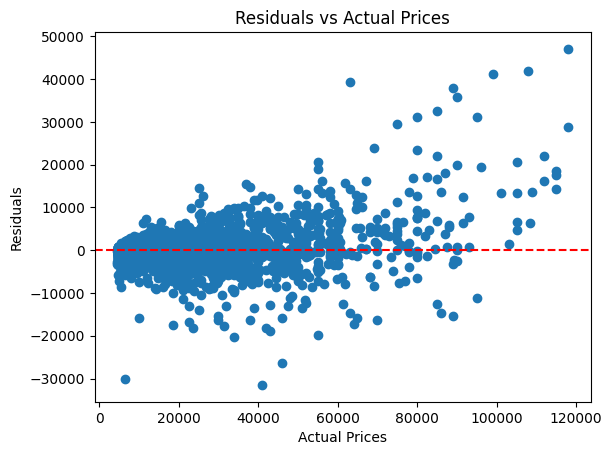

In [92]:
residuals = y_test - y_pred
plt.scatter(y_test, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Actual Prices")
plt.xlabel("Actual Prices")
plt.ylabel("Residuals")
plt.show()

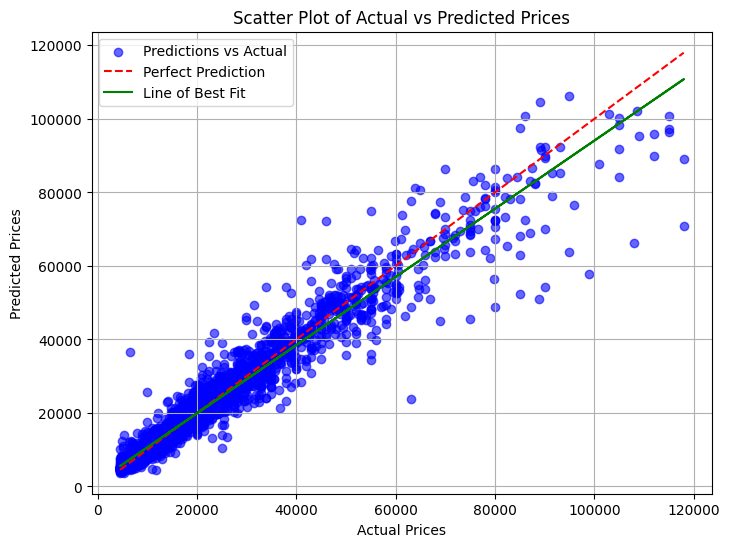

In [94]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 6))

# Scatter plot: Actual vs Predicted
plt.scatter(y_test, y_pred, alpha=0.6, label='Predictions vs Actual', color='blue')

# Add a reference line for perfect predictions
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')

# Add a line of best fit (regression line)
slope, intercept = np.polyfit(y_test, y_pred, 1)
plt.plot(y_test, slope * y_test + intercept, color='green', label='Line of Best Fit')

# Customize the plot
plt.title('Scatter Plot of Actual vs Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [97]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Assuming you already have the data loaded in `df` and 'Price_D' as the target column
X = df.drop(columns=['Price_D'])
y = df['Price_D']

# Identify categorical columns in the feature set (e.g., "Body_type", "Transmission", "Brand", etc.)
categorical_columns = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the CatBoost model
catboost_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    cat_features=categorical_columns,  # Pass the categorical column names
    random_seed=42,
    verbose=100
)

# Train the model
catboost_model.fit(X_train, y_train)

# Make predictions
y_pred = catboost_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")


0:	learn: 14732.8011341	total: 39.6ms	remaining: 39.5s
100:	learn: 4634.9224230	total: 4.89s	remaining: 43.6s
200:	learn: 4071.0471795	total: 9.7s	remaining: 38.6s
300:	learn: 3729.9531524	total: 14.9s	remaining: 34.5s
400:	learn: 3469.7879910	total: 20s	remaining: 29.9s
500:	learn: 3278.0396453	total: 25.2s	remaining: 25.1s
600:	learn: 3125.8646132	total: 30.2s	remaining: 20.1s
700:	learn: 3000.0146298	total: 35.6s	remaining: 15.2s
800:	learn: 2880.1734730	total: 40.5s	remaining: 10.1s
900:	learn: 2779.6744240	total: 45.3s	remaining: 4.98s
999:	learn: 2686.1778815	total: 50s	remaining: 0us
MAE: 2122.22
RMSE: 3978.06
R²: 0.9400


C:\Users\Burmachach.Nuradilov\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [98]:
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
mape

11.23291675671607

In [100]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Assuming you already have the data loaded in `df` and 'Price_D' as the target column
X = df.drop(columns=['Price_D'])
y = df['Price_D']
categorical_columns = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the CatBoost model
catboost_model = CatBoostRegressor(cat_features=categorical_columns, random_seed=42, verbose=0)

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'iterations': [1000, 2000, 3000],  # Number of trees in the model
    'learning_rate': [0.01, 0.05, 0.1],  # Learning rate
    'depth': [6, 8, 10, 12],  # Depth of trees
    'l2_leaf_reg': [2, 3, 5],  # L2 regularization term
    'border_count': [32, 50, 100]  # Number of splits for categorical features
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_grid,
    n_iter=10,  # Number of iterations
    cv=3,  # Number of cross-validation splits
    verbose=1,
    n_jobs=-1,  # Use all CPU cores
    random_state=42
)

# Fit the RandomizedSearchCV to the data
random_search.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found: ", random_search.best_params_)

# Use the best model from RandomizedSearchCV
best_model = random_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found:  {'learning_rate': 0.1, 'l2_leaf_reg': 2, 'iterations': 1000, 'depth': 8, 'border_count': 50}
MAE: 2014.76
RMSE: 3921.13
R²: 0.9417


C:\Users\Burmachach.Nuradilov\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [101]:
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
mape

10.546357652899063

In [36]:
df_small = df[[
    "Brand_Model_Generation",
    "Engine_Volume",
    "age",
    "Brand",
    "Drive_type",
    "Year_of_manufacture",
    "Car Year Category",
    "Mileage",
    "Model",
    "Transmission",
    "Body_type",
    "Fuel_Type",
    "average_mileage",
    "Condition_encoded",
    "Restyling",
    "Days_Ago",
    "Upped_days",
    "Month",
    "Season",
    "Actual_Date",
    "Favorites",
    "Condition",
    "Views",
    "Registration",
    "Цвет",  # Color
    "Steering_wheel_position_encoded",
    "Climate_control",
    "Alarm_system",
    "Price_D"
]]

FINAL MODEL


0:	learn: 0.6294854	test: 0.6287511	test1: 0.6286060	best: 0.6286060 (0)	total: 103ms	remaining: 1m 43s
100:	learn: 0.1636686	test: 0.1577724	test1: 0.1704596	best: 0.1704591 (98)	total: 8.5s	remaining: 1m 15s
200:	learn: 0.1432216	test: 0.1398799	test1: 0.1563955	best: 0.1563955 (200)	total: 16.6s	remaining: 1m 5s
300:	learn: 0.1302129	test: 0.1291624	test1: 0.1496881	best: 0.1496808 (299)	total: 25.1s	remaining: 58.3s
400:	learn: 0.1228719	test: 0.1233265	test1: 0.1469628	best: 0.1469628 (400)	total: 33.6s	remaining: 50.1s
500:	learn: 0.1160890	test: 0.1182134	test1: 0.1449363	best: 0.1449363 (500)	total: 42.1s	remaining: 42s
600:	learn: 0.1107047	test: 0.1141084	test1: 0.1438708	best: 0.1438677 (596)	total: 50.9s	remaining: 33.8s
700:	learn: 0.1058631	test: 0.1106246	test1: 0.1430643	best: 0.1430434 (697)	total: 59.7s	remaining: 25.5s
800:	learn: 0.1022095	test: 0.1082094	test1: 0.1424061	best: 0.1424061 (800)	total: 1m 8s	remaining: 17s
900:	learn: 0.0989016	test: 0.1060732	test1: 

C:\Users\Burmachach.Nuradilov\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Burmachach.Nuradilov\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


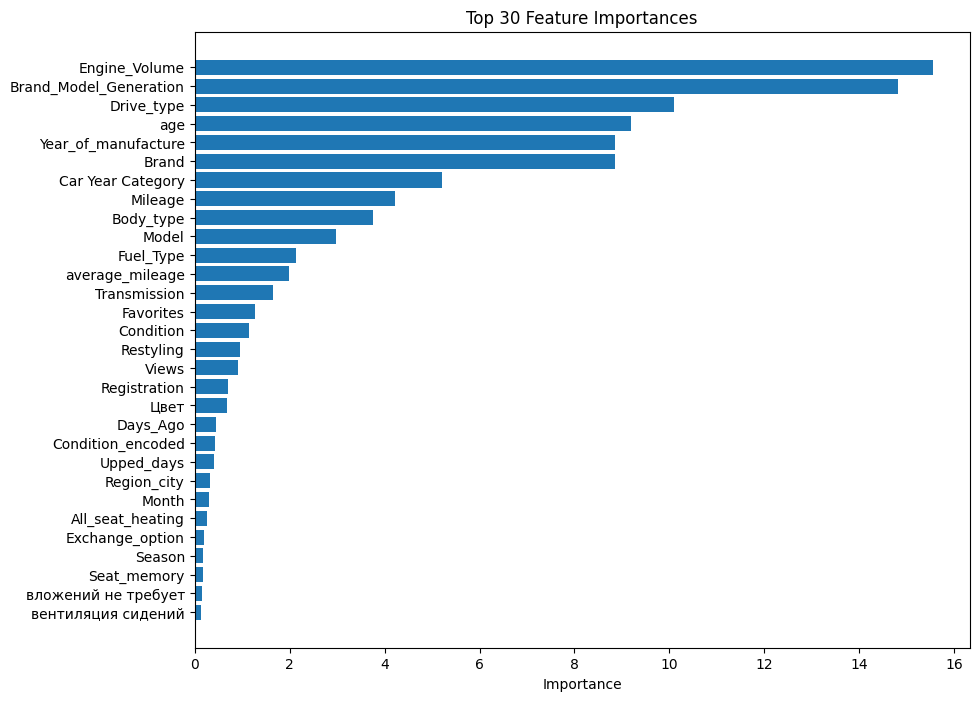

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score, 
    mean_absolute_percentage_error, median_absolute_error, explained_variance_score
)

# Prepare the features and target
X = df.drop(columns=['Price_D'])  # Features
y = df['Price_D']  # Target

# Apply log transformation to the target variable
y_log = np.log1p(y)  # Log transformation (log(x + 1))

# Identify categorical columns by their indices
categorical_columns = [
    X.columns.get_loc(col) 
    for col in X.select_dtypes(include=['object', 'category']).columns
]

# Step 2: Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42  # Use y_log for training
)
# learning_rate': 0.1, 'l2_leaf_reg': 2, 'iterations': 1000, 'depth': 8, 'border_count': 50
# Step 3: Initialize and train CatBoost with categorical features
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=8,
    l2_leaf_reg=10,
    bagging_temperature=0.7944641961311574,
    cat_features=categorical_columns,
    random_seed=42,
    verbose=100,
    border_count=50
)

model.fit(
    X_train, 
    y_train, 
    eval_set=[(X_train, y_train), (X_test, y_test)],  # Track train and test scores
    use_best_model=True,
    early_stopping_rounds=50,
    verbose=100
)

# Predict on training and test sets (log-transformed values)
y_train_pred_log = model.predict(X_train)
y_test_pred_log = model.predict(X_test)

# Reverse log transformation (since we used log1p transformation)
y_train_pred = np.expm1(y_train_pred_log)
y_test_pred = np.expm1(y_test_pred_log)

# Compute metrics for training data
train_mae = mean_absolute_error(np.expm1(y_train), y_train_pred)
train_rmse = mean_squared_error(np.expm1(y_train), y_train_pred, squared=False)
train_r2 = r2_score(np.expm1(y_train), y_train_pred)
train_mape = mean_absolute_percentage_error(np.expm1(y_train), y_train_pred) * 100
train_median_ae = median_absolute_error(np.expm1(y_train), y_train_pred)
train_explained_var = explained_variance_score(np.expm1(y_train), y_train_pred)

# Compute metrics for test data
test_mae = mean_absolute_error(np.expm1(y_test), y_test_pred)
test_rmse = mean_squared_error(np.expm1(y_test), y_test_pred, squared=False)
test_r2 = r2_score(np.expm1(y_test), y_test_pred)
test_mape = mean_absolute_percentage_error(np.expm1(y_test), y_test_pred) * 100
test_median_ae = median_absolute_error(np.expm1(y_test), y_test_pred)
test_explained_var = explained_variance_score(np.expm1(y_test), y_test_pred)

# Display the results
print("\n📌 Model Performance Metrics:\n")
print(f"🔹 Train Data:")
print(f"   - MAE: {train_mae:.2f}")
print(f"   - RMSE: {train_rmse:.2f}")
print(f"   - R² Score: {train_r2:.4f}")
print(f"   - MAPE: {train_mape:.2f}%")
print(f"   - Median Absolute Error: {train_median_ae:.2f}")
print(f"   - Explained Variance Score: {train_explained_var:.4f}\n")

print(f"🔹 Test Data:")
print(f"   - MAE: {test_mae:.2f}")
print(f"   - RMSE: {test_rmse:.2f}")
print(f"   - R² Score: {test_r2:.4f}")
print(f"   - MAPE: {test_mape:.2f}%")
print(f"   - Median Absolute Error: {test_median_ae:.2f}")
print(f"   - Explained Variance Score: {test_explained_var:.4f}")

# Display the results
# print(f"Mean Absolute Error (MAE): {mae:.2f}")
# print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
# print(f"R² Score: {r2:.4f}")
# print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
# print(f"Median Absolute Error: {median_ae:.2f}")
# print(f"Explained Variance Score: {explained_var:.4f}")

# Feature Importance Visualization
feature_importances = model.get_feature_importance()
feature_names = X.columns

feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(feat_imp_df['Feature'][:30][::-1], feat_imp_df['Importance'][:30][::-1])
plt.xlabel('Importance')
plt.title('Top 30 Feature Importances')
plt.show()


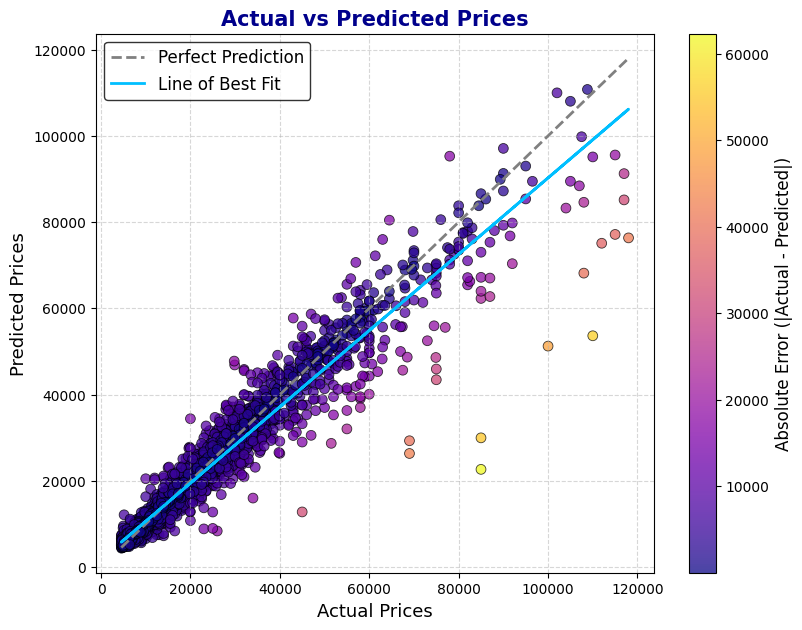

In [146]:
import matplotlib.pyplot as plt
import numpy as np

# Compute actual prices and absolute errors
actual_prices = np.expm1(y_test)
absolute_errors = np.abs(actual_prices - y_test_pred)

plt.figure(figsize=(9, 7))

# Scatter plot: Actual vs Predicted, color-coded by absolute error
scatter = plt.scatter(actual_prices, y_test_pred, c=absolute_errors, cmap='plasma', s=50, alpha=0.75, edgecolors='k', linewidth=0.6)

# Add a color bar for error magnitude
cbar = plt.colorbar(scatter)
cbar.set_label("Absolute Error (|Actual - Predicted|)", fontsize=12)

# Add a reference line for perfect predictions
plt.plot([min(actual_prices), max(actual_prices)], [min(actual_prices), max(actual_prices)], 
         color='gray', linestyle='--', linewidth=2, label='Perfect Prediction')

# Add a regression line (line of best fit)
slope, intercept = np.polyfit(actual_prices, y_test_pred, 1)
plt.plot(actual_prices, slope * actual_prices + intercept, 
         color='deepskyblue', linestyle='-', linewidth=2, label='Line of Best Fit')

# Customize the plot
plt.title('Actual vs Predicted Prices', fontsize=15, fontweight='bold', color='darkblue')
plt.xlabel('Actual Prices', fontsize=13, color='black')
plt.ylabel('Predicted Prices', fontsize=13, color='black')
plt.legend(fontsize=12, loc='upper left', frameon=True, facecolor='white', edgecolor='black')
plt.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.show()


In [147]:
df_results = pd.DataFrame({
    'Цена': np.expm1(y_test),
    'Predicted_Price': y_test_pred
})

# Ensure the DataFrame is sorted or indexed correctly
df_results.reset_index(drop=True, inplace=True)
bins = [4500, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, 120000]
labels = ['4.5-10k', '10-20k', '20-30k', '30-40k', '40-50k', '50-60k', '60-70k', '70-80k', '80-90k', '90-100k', '100-110k', '110-120k']

# Create custom bins using pd.cut
df_results['Price_Bin'] = pd.cut(df_results['Цена'], bins=bins, labels=labels, right=False)
def calculate_errors(group):
    mae = np.mean(np.abs(group['Цена'] - group['Predicted_Price']))
    rmse = np.sqrt(np.mean((group['Цена'] - group['Predicted_Price'])**2))
    mape = np.mean(np.abs((group['Цена'] - group['Predicted_Price']) / group['Цена'])) * 100
    return pd.Series({'MAE': mae, 'RMSE': rmse, 'MAPE': mape})

# Apply the function to each bin
error_metrics = df_results.groupby('Price_Bin').apply(calculate_errors).reset_index()

error_metrics

C:\Users\Burmachach.Nuradilov\AppData\Local\Temp\ipykernel_20212\254877376.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_metrics = df_results.groupby('Price_Bin').apply(calculate_errors).reset_index()
C:\Users\Burmachach.Nuradilov\AppData\Local\Temp\ipykernel_20212\254877376.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  error_metrics = df_results.groupby('Price_Bin').apply(calculate_errors).reset_index()


Price_Bin           MAE          RMSE       MAPE
0    4.5-10k    721.063785    989.231067  10.657793
1     10-20k   1202.565146   1707.753743   8.318642
2     20-30k   2534.836724   3529.313811  10.278338
3     30-40k   3217.158701   4294.356581   9.384788
4     40-50k   5166.727739   6841.514417  11.627907
5     50-60k   6171.607602   8392.808057  11.266631
6     60-70k   9071.026774  12566.072834  14.070890
7     70-80k  10063.891471  13065.752537  13.436210
8     80-90k  12421.086571  18889.508823  14.732620
9    90-100k   8912.461460  10745.257536   9.673482
10  100-110k  21562.124230  27479.697939  20.319636
11  110-120k  32243.440070  33130.852635  27.884828

In [156]:
df_results = pd.DataFrame({
    'Цена': np.expm1(y_test),
    'Predicted_Price': y_test_pred
})

# Ensure the DataFrame is sorted or indexed correctly
df_results.reset_index(drop=True, inplace=True)
bins = [4500, 60000, 90000, 120000]
labels = ['4.5-60k',  '60-90k', '90-120k']

# Create custom bins using pd.cut
df_results['Price_Bin'] = pd.cut(df_results['Цена'], bins=bins, labels=labels, right=False)
def calculate_errors(group):
    mae = np.mean(np.abs(group['Цена'] - group['Predicted_Price']))
    rmse = np.sqrt(np.mean((group['Цена'] - group['Predicted_Price'])**2))
    mape = np.mean(np.abs((group['Цена'] - group['Predicted_Price']) / group['Цена'])) * 100
    return pd.Series({'MAE': mae, 'RMSE': rmse, 'MAPE': mape})

# Apply the function to each bin
error_metrics = df_results.groupby('Price_Bin').apply(calculate_errors).reset_index()

error_metrics

C:\Users\Burmachach.Nuradilov\AppData\Local\Temp\ipykernel_20212\3242323154.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_metrics = df_results.groupby('Price_Bin').apply(calculate_errors).reset_index()
C:\Users\Burmachach.Nuradilov\AppData\Local\Temp\ipykernel_20212\3242323154.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  error_metrics = df_results.groupby('Price_Bin').apply(calculate_errors).reset_index()


Price_Bin           MAE          RMSE       MAPE
0   4.5-60k   1656.931906   2825.058031   9.590895
1    60-90k  10257.218243  14698.941615  14.084158
2   90-120k  19333.240921  24496.451317  18.138551

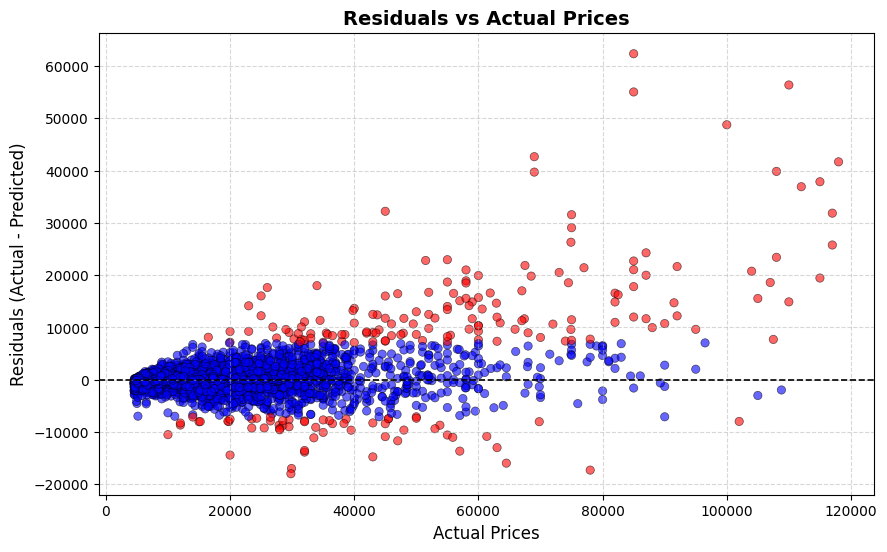

In [148]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate residuals
residuals = np.expm1(y_test) - y_test_pred
actual_prices = np.expm1(y_test)

# Define threshold for large residuals (e.g., top 10% of absolute residuals)
threshold = np.percentile(np.abs(residuals), 95)

# Create color labels: Red for large residuals, Blue for others
colors = np.where(np.abs(residuals) > threshold, 'red', 'blue')

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(actual_prices, residuals, c=colors, alpha=0.6, edgecolors='k', linewidth=0.5)

# Highlight horizontal zero line
plt.axhline(0, color='black', linestyle='--', linewidth=1.2)

# Titles and labels
plt.title("Residuals vs Actual Prices", fontsize=14, fontweight='bold')
plt.xlabel("Actual Prices", fontsize=12)
plt.ylabel("Residuals (Actual - Predicted)", fontsize=12)

# Improve grid visibility
plt.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.show()


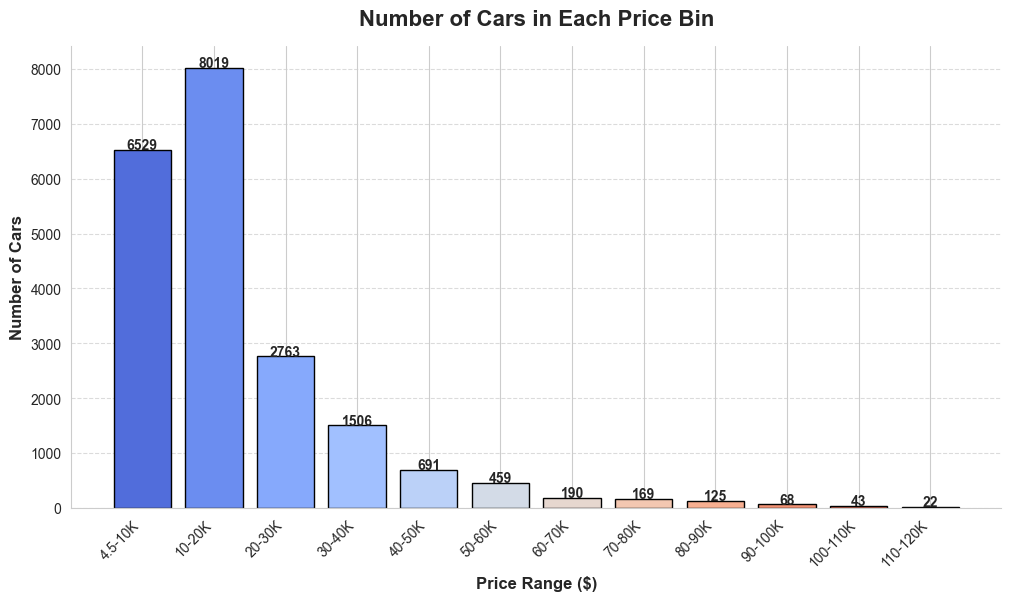

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have the DataFrame `df` with 'Price_D' as the price column

# Define the bins for price range and labels
bins = [4500, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, 120000]
labels = ['4.5-10K', '10-20K', '20-30K', '30-40K', '40-50K', '50-60K', '60-70K', '70-80K', '80-90K', '90-100K', '100-110K', '110-120K']

# Assign each car to a bin based on its price
df['Price_Bin'] = pd.cut(df['Price_D'], bins=bins, labels=labels, include_lowest=True)

# Count the number of cars in each bin, preserving order
price_bin_counts = df['Price_Bin'].value_counts().reindex(labels)

# Set seaborn style
sns.set_style("whitegrid")

# Create the plot
plt.figure(figsize=(12, 6))
bars = plt.bar(price_bin_counts.index, price_bin_counts.values, color=sns.color_palette("coolwarm", len(labels)), edgecolor="black")

# Add value labels above bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 10, f"{int(yval)}", ha='center', fontsize=10, fontweight='bold')

# Customize the plot
plt.title('Number of Cars in Each Price Bin', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Price Range ($)', fontsize=12, fontweight='bold')
plt.ylabel('Number of Cars', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Remove top and right borders
sns.despine()

# Show the plot
plt.show()


In [129]:
df_noage['age']

0         3
1        14
2         6
3        19
4         7
5         1
6         4
7         8
8        22
9        22
10       21
11       25
12       23
13        7
14        7
15        6
16       22
17        8
18        7
19       19
20        5
21        1
22        9
23        8
24       17
25       20
26       15
27        4
28       21
29        8
30       15
31       19
32       21
33       25
34        9
35       17
36       17
37       24
38       17
39       13
40       14
41        7
42       23
43        7
44       25
45        6
46        9
47       10
48       18
49        7
50       20
51       16
52        3
53        7
54       22
55        7
56       15
57       23
58        5
59        7
60        6
61       17
62        7
63        7
64        6
65        7
66        7
67        6
68       15
69       15
70        5
71        2
72       25
73        8
74        6
75       22
76        7
77       22
78       21
79       21
80        5
81       19
82       23
83  

In [ ]:
df['Condition'].value_counts()

In [130]:
df_noage = df.drop(columns=['Price_Bin', 'age'])

0:	learn: 0.6284048	test: 0.6276435	test1: 0.6272253	best: 0.6272253 (0)	total: 102ms	remaining: 1m 41s
100:	learn: 0.1647876	test: 0.1583315	test1: 0.1712872	best: 0.1712872 (100)	total: 8.31s	remaining: 1m 13s
200:	learn: 0.1451049	test: 0.1415492	test1: 0.1585120	best: 0.1585120 (200)	total: 16.5s	remaining: 1m 5s
300:	learn: 0.1326939	test: 0.1312017	test1: 0.1523669	best: 0.1523669 (300)	total: 26.3s	remaining: 1m 1s
400:	learn: 0.1236857	test: 0.1239089	test1: 0.1484408	best: 0.1484408 (400)	total: 36.8s	remaining: 55s
500:	learn: 0.1165935	test: 0.1183471	test1: 0.1461733	best: 0.1461733 (500)	total: 47.4s	remaining: 47.2s
600:	learn: 0.1113296	test: 0.1144879	test1: 0.1445730	best: 0.1445704 (599)	total: 56.2s	remaining: 37.3s
700:	learn: 0.1074851	test: 0.1118240	test1: 0.1437206	best: 0.1437089 (699)	total: 1m 4s	remaining: 27.6s
800:	learn: 0.1027946	test: 0.1083416	test1: 0.1427660	best: 0.1427517 (794)	total: 1m 13s	remaining: 18.2s
900:	learn: 0.0992324	test: 0.1059158	te

C:\Users\Burmachach.Nuradilov\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Burmachach.Nuradilov\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


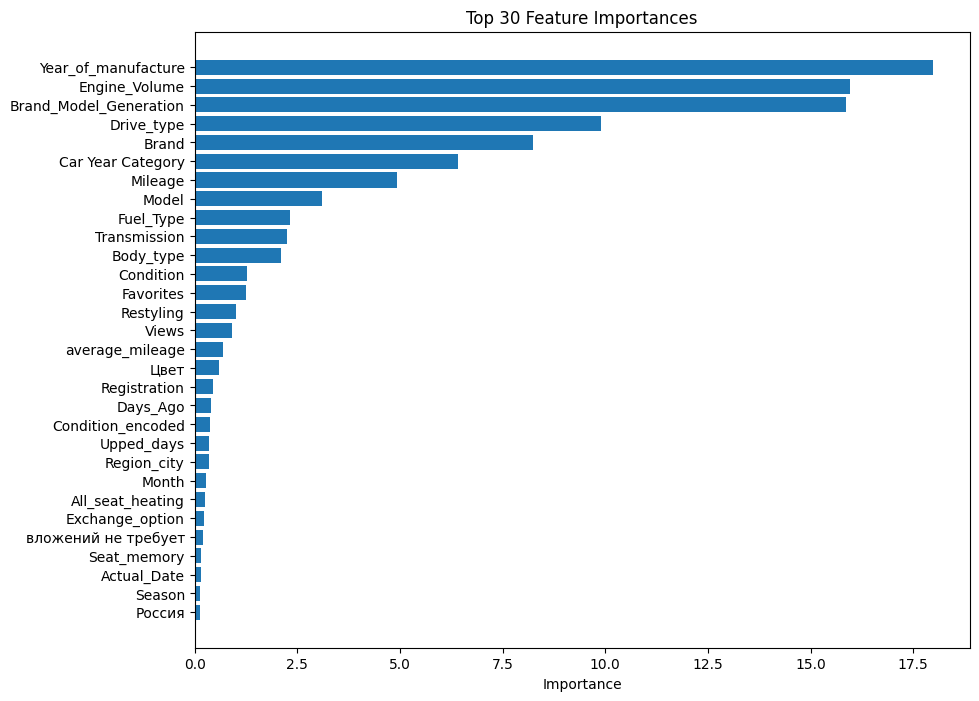

In [145]:
X = df_noage.drop(columns=['Price_D'])  # Features
y = df_noage['Price_D']  # Target

# Apply log transformation to the target variable
y_log = np.log1p(y)  # Log transformation (log(x + 1))

# Identify categorical columns by their indices
categorical_columns = [
    X.columns.get_loc(col) 
    for col in X.select_dtypes(include=['object', 'category']).columns
]

# Step 2: Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42  # Use y_log for training
)

# Step 3: Initialize and train CatBoost with categorical features
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=8,
    l2_leaf_reg=10,
    bagging_temperature=0.7944641961311574,
    cat_features=categorical_columns,
    random_seed=42,
    verbose=100,
    border_count=50
)

model.fit(
    X_train, 
    y_train, 
    eval_set=[(X_train, y_train), (X_test, y_test)],  # Track train and test scores
    use_best_model=True,
    early_stopping_rounds=50,  # Early stopping
    verbose=100
)

# Predict on training and test sets (log-transformed values)
y_train_pred_log = model.predict(X_train)
y_test_pred_log = model.predict(X_test)

# Reverse log transformation (since we used log1p transformation)
y_train_pred = np.expm1(y_train_pred_log)  # Reverse the transformation on predictions
y_test_pred = np.expm1(y_test_pred_log)  # Reverse the transformation on predictions

# Compute metrics for training data
train_mae = mean_absolute_error(np.expm1(y_train), y_train_pred)  # Reverse log on original y_train
train_rmse = mean_squared_error(np.expm1(y_train), y_train_pred, squared=False)
train_r2 = r2_score(np.expm1(y_train), y_train_pred)
train_mape = mean_absolute_percentage_error(np.expm1(y_train), y_train_pred) * 100
train_median_ae = median_absolute_error(np.expm1(y_train), y_train_pred)
train_explained_var = explained_variance_score(np.expm1(y_train), y_train_pred)

# Compute metrics for test data
test_mae = mean_absolute_error(np.expm1(y_test), y_test_pred)  # Reverse log on original y_test
test_rmse = mean_squared_error(np.expm1(y_test), y_test_pred, squared=False)
test_r2 = r2_score(np.expm1(y_test), y_test_pred)
test_mape = mean_absolute_percentage_error(np.expm1(y_test), y_test_pred) * 100
test_median_ae = median_absolute_error(np.expm1(y_test), y_test_pred)
test_explained_var = explained_variance_score(np.expm1(y_test), y_test_pred)

# Display the results
print("\n📌 Model Performance Metrics:\n")
print(f"🔹 Train Data:")
print(f"   - MAE: {train_mae:.2f}")
print(f"   - RMSE: {train_rmse:.2f}")
print(f"   - R² Score: {train_r2:.4f}")
print(f"   - MAPE: {train_mape:.2f}%")
print(f"   - Median Absolute Error: {train_median_ae:.2f}")
print(f"   - Explained Variance Score: {train_explained_var:.4f}\n")

print(f"🔹 Test Data:")
print(f"   - MAE: {test_mae:.2f}")
print(f"   - RMSE: {test_rmse:.2f}")
print(f"   - R² Score: {test_r2:.4f}")
print(f"   - MAPE: {test_mape:.2f}%")
print(f"   - Median Absolute Error: {test_median_ae:.2f}")
print(f"   - Explained Variance Score: {test_explained_var:.4f}")

# Feature Importance Visualization
feature_importances = model.get_feature_importance()
feature_names = X.columns

feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(feat_imp_df['Feature'][:30][::-1], feat_imp_df['Importance'][:30][::-1])
plt.xlabel('Importance')
plt.title('Top 30 Feature Importances')
plt.show()

In [3]:
import pandas as pd
import plotly.graph_objects as go

# Data for the table
data = {
    "Model": ["CatBoost", "Random Forest", "DecisionTreeRegressor", "GradientBoostingRegressor", "PLSRegression"],
    "MAE": [1993.41, 2860.53, 2860.53, 3291.16, 3955.81],
    "RMSE": [4245.05, 4507.42, 5835.22, 5632.97, 6538.53],
    "R²": [0.9290, 0.9199, 0.8708, 0.8796, 0.8378],
    "MAPE": ["9.65%", "11.82%", "14.32%", "18.35%", "25.98%"]
}

# Create DataFrame
df = pd.DataFrame(data)

# Highlight CatBoost row
colors = ['#c3f7c3' if model == 'CatBoost' else 'white' for model in df['Model']]

# Create a styled table
fig = go.Figure(data=[go.Table(
    header=dict(
        values=list(df.columns),
        fill_color='#4472c4',
        font=dict(color='white', size=14),
        align='center'
    ),
    cells=dict(
        values=[df[col] for col in df.columns],
        fill_color=[colors] * len(df.columns),
        align='center',
        font=dict(size=13)
    ))
])

fig.update_layout(
    title='Model Performance Comparison',
    title_font_size=20,
    margin=dict(l=20, r=20, t=60, b=20)
)

fig.show()


FINAL FINAL

In [43]:
df_noyearcat = df.drop(columns=['Price_Bin', 'Car Year Category'])


KeyError: "['Price_Bin'] not found in axis"

In [44]:
df_noyearcatyear = df.drop(columns=[ 'Car Year Category', 'Year_of_manufacture'])

In [53]:
df_noyearcatyear.head()

Views  Favorites  Mileage          Body_type        Цвет Transmission  \
0    375          1    55000              седан      черный      автомат   
1    674         15   250000  внедорожник 5 дв.      черный     вариатор   
2    318          2    64373  внедорожник 5 дв.       белый      автомат   
3    709         11   280000              седан  коричневый      автомат   
4    147          2   124000              седан      черный      автомат   

  Drive_type Steering_wheel_position  Condition Customs_clearance Region_city  \
0   передний                   слева  идеальное        растаможен      Бишкек   
1     полный                   слева  идеальное        растаможен      Бишкек   
2     полный                   слева  идеальное        растаможен      Бишкек   
3   передний                   слева    хорошее        растаможен      Бишкек   
4   передний                   слева  идеальное        растаможен      Бишкек   

  Registration     Exchange_option Installment_option    Brand       Model  \
0   Кыргызстан  рассмотрю варианты                нет   Toyota       Camry   
1   Кыргызстан  рассмотрю варианты                нет   Toyota  Highlander   
2   Кыргызстан  рассмотрю варианты                нет      Kia    Sportage   
3   Кыргызстан  рассмотрю варианты                нет    Honda       Civic   
4   Кыргызстан  рассмотрю варианты                нет  Hyundai      Sonata   

   Restyling      Brand_Model_Generation  Days_Ago  Upped_days Fuel_Type  \
0       True    Toyota Camry VIII (XV70)        24           9    бензин   
1       True  Toyota Highlander II (U40)        66          66    гибрид   
2       True             Kia Sportage IV        66          66    бензин   
3      False            Honda Civic VIII        66          66    бензин   
4       True     Hyundai Sonata VII (LF)        66          66    бензин   

   Engine_Volume          Actual_Date     Month  Season  Price_D  \
0            3.5  2024-12-14 12:32:00  December  Winter    32000   
1            3.5  2024-11-02 12:33:00  November  Autumn    18500   
2            2.4  2024-11-02 12:33:00  November  Autumn    14200   
3            1.8  2024-11-02 12:33:00  November  Autumn     4800   
4            2.4  2024-11-02 12:33:00  November  Autumn    11900   

   полный электропакет  Alarm_system  Remote_start  Air_conditioner  \
0                    1             1             0                1   
1                    1             0             0                1   
2                    0             0             0                0   
3                    0             0             0                0   
4                    0             1             0                1   

   Climate_control  газобалонное оборудование  круиз-контроль  \
0                1                          0               0   
1                1                          0               0   
2                0                          0               0   
3                0                          0               0   
4                1                          0               0   

   Front_seat_heating  All_seat_heating  обогрев зеркал  Xenon_headlights  \
0                   0                 1               0                 0   
1                   1                 0               0                 0   
2                   0                 0               0                 0   
3                   0                 0               0                 0   
4                   1                 0               0                 0   

   Bi_xenon_headlights  Headlight_washer  Air_suspension  Seat_memory  \
0                    0                 0               0            0   
1                    0                 0               0            0   
2                    0                 0               0            0   
3                    0                 0               0            0   
4                    0                 1               0            1   

   S

C:\Users\Burmachach.Nuradilov\AppData\Local\Temp\ipykernel_26856\3034040967.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


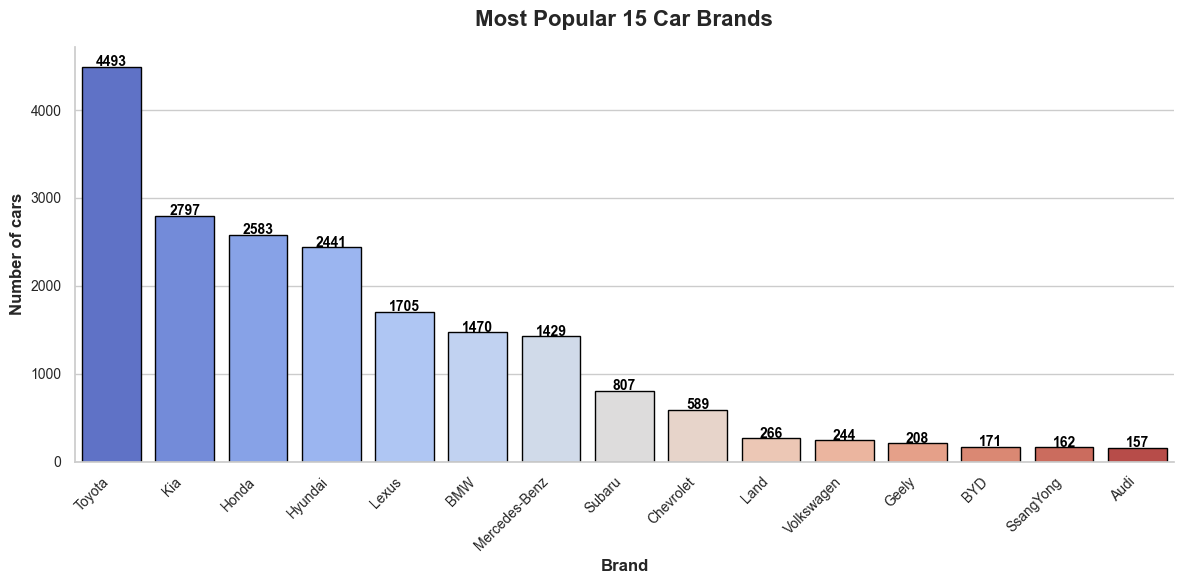

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the top 20 most common brands
top_brands = df_noyearcatyear['Brand'].value_counts().head(15)

# Set a modern style
plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")

# Create a barplot with enhanced aesthetics
sns.barplot(
    x=top_brands.index, 
    y=top_brands.values, 
    palette="coolwarm",  # Use a nice color gradient
    edgecolor="black"
)

# Beautify the plot
plt.title('Most Popular 15 Car Brands', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Brand', fontsize=12, fontweight='bold')
plt.ylabel('Number of cars', fontsize=12, fontweight='bold')

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# Remove top and right borders for a cleaner look
sns.despine()

# Add value labels on top of bars
for i, value in enumerate(top_brands.values):
    plt.text(i, value + 5, str(value), ha='center', fontsize=10, fontweight='bold', color='black')

plt.tight_layout()
plt.show()


0:	learn: 0.6262699	test: 0.6257146	test1: 0.6287360	best: 0.6287360 (0)	total: 139ms	remaining: 2m 18s
100:	learn: 0.1635278	test: 0.1562530	test1: 0.1653942	best: 0.1653942 (100)	total: 11s	remaining: 1m 38s
200:	learn: 0.1410391	test: 0.1366321	test1: 0.1510417	best: 0.1510417 (200)	total: 22.3s	remaining: 1m 28s
300:	learn: 0.1312280	test: 0.1284753	test1: 0.1465635	best: 0.1465604 (299)	total: 33.8s	remaining: 1m 18s
400:	learn: 0.1231938	test: 0.1220802	test1: 0.1433014	best: 0.1433014 (400)	total: 44.4s	remaining: 1m 6s
500:	learn: 0.1178668	test: 0.1179664	test1: 0.1415936	best: 0.1415936 (500)	total: 55.4s	remaining: 55.1s
600:	learn: 0.1124754	test: 0.1139422	test1: 0.1401211	best: 0.1401129 (599)	total: 1m 6s	remaining: 43.9s
700:	learn: 0.1076857	test: 0.1103227	test1: 0.1390259	best: 0.1390259 (700)	total: 1m 16s	remaining: 32.7s
800:	learn: 0.1027847	test: 0.1068831	test1: 0.1379695	best: 0.1379695 (800)	total: 1m 27s	remaining: 21.7s
900:	learn: 0.0990039	test: 0.1042558

C:\Users\Burmachach.Nuradilov\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Burmachach.Nuradilov\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


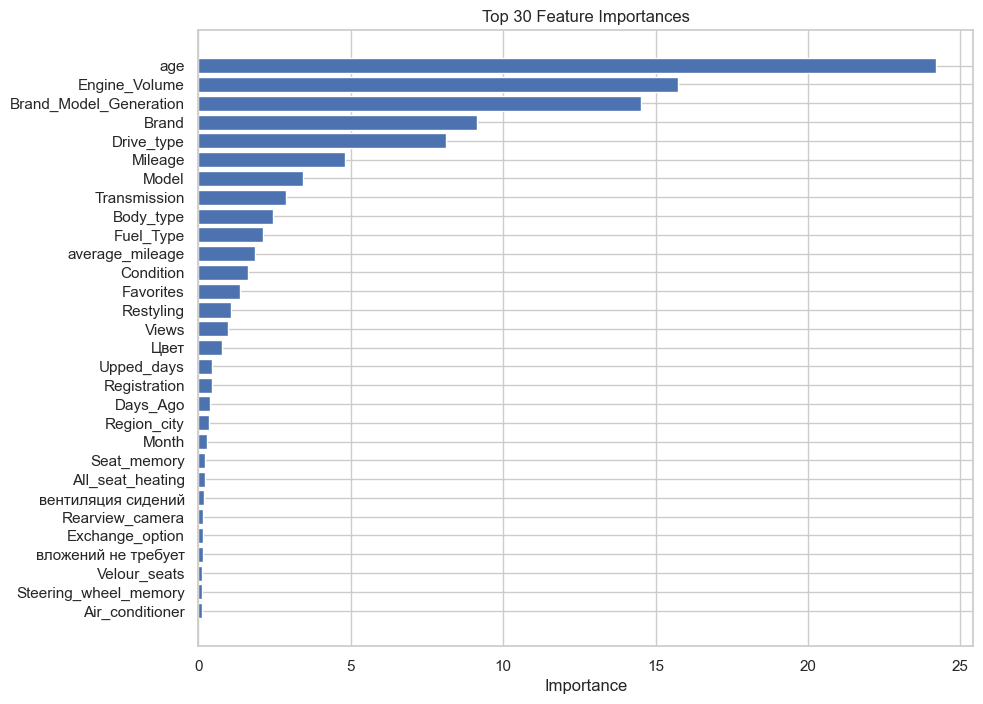

In [55]:
X = df_noyearcatyear.drop(columns=['Price_D'])  # Features
y = df_noyearcatyear['Price_D']  # Target

# Apply log transformation to the target variable
y_log = np.log1p(y)  # Log transformation (log(x + 1))

# Identify categorical columns by their indices
categorical_columns = [
    X.columns.get_loc(col) 
    for col in X.select_dtypes(include=['object', 'category']).columns
]

# Step 2: Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42  # Use y_log for training
)

# Step 3: Initialize and train CatBoost with categorical features
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=8,
    l2_leaf_reg=10,
    bagging_temperature=0.7944641961311574,
    cat_features=categorical_columns,
    random_seed=42,
    verbose=100,
    border_count=50
)

model.fit(
    X_train, 
    y_train, 
    eval_set=[(X_train, y_train), (X_test, y_test)],  # Track train and test scores
    use_best_model=True,
    early_stopping_rounds=50,  # Early stopping
    verbose=100
)

# Predict on training and test sets (log-transformed values)
y_train_pred_log = model.predict(X_train)
y_test_pred_log = model.predict(X_test)

# Reverse log transformation (since we used log1p transformation)
y_train_pred = np.expm1(y_train_pred_log)  # Reverse the transformation on predictions
y_test_pred = np.expm1(y_test_pred_log)  # Reverse the transformation on predictions

# Compute metrics for training data
train_mae = mean_absolute_error(np.expm1(y_train), y_train_pred)  # Reverse log on original y_train
train_rmse = mean_squared_error(np.expm1(y_train), y_train_pred, squared=False)
train_r2 = r2_score(np.expm1(y_train), y_train_pred)
train_mape = mean_absolute_percentage_error(np.expm1(y_train), y_train_pred) * 100
train_median_ae = median_absolute_error(np.expm1(y_train), y_train_pred)
train_explained_var = explained_variance_score(np.expm1(y_train), y_train_pred)

# Compute metrics for test data
test_mae = mean_absolute_error(np.expm1(y_test), y_test_pred)  # Reverse log on original y_test
test_rmse = mean_squared_error(np.expm1(y_test), y_test_pred, squared=False)
test_r2 = r2_score(np.expm1(y_test), y_test_pred)
test_mape = mean_absolute_percentage_error(np.expm1(y_test), y_test_pred) * 100
test_median_ae = median_absolute_error(np.expm1(y_test), y_test_pred)
test_explained_var = explained_variance_score(np.expm1(y_test), y_test_pred)

# Display the results
print("\n📌 Model Performance Metrics:\n")
print(f"🔹 Train Data:")
print(f"   - MAE: {train_mae:.2f}")
print(f"   - RMSE: {train_rmse:.2f}")
print(f"   - R² Score: {train_r2:.4f}")
print(f"   - MAPE: {train_mape:.2f}%")
print(f"   - Median Absolute Error: {train_median_ae:.2f}")
print(f"   - Explained Variance Score: {train_explained_var:.4f}\n")

print(f"🔹 Test Data:")
print(f"   - MAE: {test_mae:.2f}")
print(f"   - RMSE: {test_rmse:.2f}")
print(f"   - R² Score: {test_r2:.4f}")
print(f"   - MAPE: {test_mape:.2f}%")
print(f"   - Median Absolute Error: {test_median_ae:.2f}")
print(f"   - Explained Variance Score: {test_explained_var:.4f}")

# Feature Importance Visualization
feature_importances = model.get_feature_importance()
feature_names = X.columns

feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(feat_imp_df['Feature'][:30][::-1], feat_imp_df['Importance'][:30][::-1])
plt.xlabel('Importance')
plt.title('Top 30 Feature Importances')
plt.show()

In [83]:
# Step 1: Merge brand information from the original dataset based on X_test index
df_results['brand'] = df_noyearcatyear.loc[X_test.index, 'Brand'].values

# Step 2: Reverse the log transformation to get the actual and predicted prices
df_results['Actual_Price'] = np.expm1(y_test)  # Reverse log transformation on y_test
df_results['Predicted_Price'] = np.expm1(y_test_pred)  # Reverse transformation on predictions

# Step 3: Remove rows where the Actual_Price is zero or NaN
df_results = df_results[df_results['Actual_Price'] > 0]

# Step 4: Calculate Percentage Error (MAPE)
df_results['Percentage_Error'] = (abs(df_results['Actual_Price'] - df_results['Predicted_Price']))

# # Step 5: Group by brand and calculate the average percentage error for each brand
# brand_error = df_results.groupby('brand').agg(
#     Mean_Percentage_Error=('Percentage_Error', 'mean'),
#     Mean_Actual_Price=('Actual_Price', 'mean'),
#     Mean_Predicted_Price=('Predicted_Price', 'mean'),
#     Count=('brand', 'count')  # Optional: to know how many cars are from each brand
# ).reset_index()

# # Sort the brands by mean percentage error, optionally
# brand_error_sorted = brand_error.sort_values(by='Mean_Percentage_Error', ascending=False)

# # Step 6: Display the result
# print(brand_error_sorted)

# Optionally, save the result to a CSV file
# brand_error_sorted.to_csv('brand_error_analysis.csv', index=False)


ValueError: Length of values (4089) does not match length of index (776)

In [87]:
# Step 1: Reverse the log transformation on y_train to get the actual prices
y_train_actual = np.expm1(y_train)  # Reverse log transformation on y_train

# Step 2: Predict the prices using the trained model
y_train_pred_log = model.predict(X_train)
y_train_pred = np.expm1(y_train_pred_log)  # Reverse log transformation on predictions

# Step 3: Create a DataFrame with the actual and predicted prices
df_train_results = pd.DataFrame({
    'Actual_Price': y_train_actual,
    'Predicted_Price': y_train_pred
})

# Optionally, if you want to add these to the original y_train:
y_train_f = pd.concat([X_train, df_train_results], axis=1)

# Display the first few rows to check
y_train_f.head()


Views  Favorites  Mileage  Body_type         Цвет Transmission  \
16499   1327          9       10      седан       черный     вариатор   
9644     933          7   360000    минивэн  серебристый      автомат   
5430     259          0   249000      седан       черный        робот   
10534   1359         18   115496    минивэн       черный      автомат   
18531    197          3   290000  универсал       черный     механика   

      Drive_type Steering_wheel_position Condition Customs_clearance  \
16499   передний                   слева   хорошее        растаможен   
9644    передний                  справа   хорошее        растаможен   
5430    передний                   слева   хорошее        растаможен   
10534     полный                   слева   хорошее        растаможен   
18531   передний                   слева   хорошее        растаможен   

                               Region_city Registration      Exchange_option  \
16499                               Бишкек   Кыргызстан   рассмотрю варианты   
9644   Кочкор-Ата, Джалал-Абадская область   Кыргызстан   рассмотрю варианты   
5430                                Бишкек   Кыргызстан   рассмотрю варианты   
10534        Кызыл-Кия, Баткенская область   Кыргызстан   рассмотрю варианты   
18531                               Бишкек   Кыргызстан  обмен не предлагать   

      Installment_option    Brand    Model  Restyling  \
16499                нет  Hyundai  Elantra       True   
9644                 нет    Honda  Stepwgn       True   
5430                 нет   Toyota  Corolla      False   
10534                нет  Hyundai   Starex       True   
18531                нет    Mazda        6      False   

              Brand_Model_Generation  Days_Ago  Upped_days Fuel_Type  \
16499      Hyundai Elantra VII (CN7)        90           0    бензин   
9644                Honda Stepwgn II        60          30    бензин   
5430   Toyota Corolla X (E140, E150)        66          66    бензин   
10534        Hyundai Starex (H-1) II        60          30    дизель   
18531                          Mazda         9           4    бензин   

       Engine_Volume          Actual_Date     Month  Season  \
16499            1.5  2024-10-07 02:53:00   October  Autumn   
9644             2.0  2024-11-07 22:54:00  November  Autumn   
5430             1.6  2024-11-01 14:45:00  November  Autumn   
10534            2.5  2024-11-08 01:16:00  November  Autumn   
18531            2.0  2024-12-27 06:53:00  December  Winter   

       полный электропакет  Alarm_system  Remote_start  Air_conditioner  \
16499                    0             0             0                0   
9644                     0             0             0                1   
5430                     0             0             0                0   
10534                    1             1             1                1   
18531                    0             1             0                0   

       Climate_control  газобалонное оборудование  круиз-контроль  \
16499                0                          0               0   
9644                 0                          0               0   
5430                 0                          0               0   
10534                1                          0               0   
18531                0                          0               0   

       Front_seat_heating  All_seat_heating  обогрев зеркал  Xenon_headlights  \
16499                   0                 0               0                 0   
9644                    0                 0               0                 1   
5430                    0                 0               0                 0   
10534                   1                 1               1                 0   
18531                   1                 0               0                 0   

       Bi_xenon_headlights  Headlight_washer  Air_suspension  Seat_memory  \
16499                    0                 0               0         

In [94]:
# Step 1: Calculate the difference between Actual_Price and Predicted_Price
y_train_f['Price_Difference'] = y_train_f['Actual_Price'] - y_train_f['Predicted_Price']

# Step 2: Group by Brand and calculate the mean of Price_Difference
brand_price_difference = y_train_f.groupby('Brand')['Price_Difference'].mean().reset_index()

# Display the result
brand_price_difference

Brand  Price_Difference
0            Audi        734.912590
1             BMW        614.545672
2             BYD        -65.597443
3         Changan       -789.211779
4       Chevrolet        -29.751849
5          Daewoo        973.591622
6            Ford       1212.190706
7           Geely        182.392585
8         Genesis       -481.338257
9           Honda        103.273989
10        Hyundai         63.257784
11            Kia         70.662404
12           Land        643.549757
13          Lexus        180.870663
14        LiXiang       1662.183769
15          Mazda       -464.713515
16  Mercedes-Benz        376.606549
17     Mitsubishi        526.409402
18         Nissan         69.527015
19           Opel        -53.735704
20        Renault       -233.275158
21      SsangYong       1095.453696
22         Subaru        335.584774
23          Tesla       -463.287868
24         Toyota        137.972088
25     Volkswagen         86.489740
26    Weltmeister        882.922069
27          Zeekr       1716.528326
28            ВАЗ        -80.467629

In [120]:
# Calculate average error and car count per registration type
# These are your one-hot encoded columns
registration_cols = ['Кыргызстан', 'Не стоит на учёте', 'Россия', 'Армения', 'Другая страна', 'Казахстан', 'Абхазия', 'Беларусь']

# Get the registration country for each row (the column name where the value is 1)
df_noyearcatyear['Registration_Country'] = df_noyearcatyear[registration_cols].idxmax(axis=1)

registration_summary = df_noyearcatyear.groupby('Registration_Country').agg(
    Avg_Error=('Price_Difference', 'mean'),
    Car_Count=('Price_Difference', 'count')
).reset_index()
registration_summary

KeyError: "Column(s) ['Price_Difference'] do not exist"

In [121]:
df_noyearcatyear.head()

Views  Favorites  Mileage          Body_type        Цвет Transmission  \
0    375          1    55000              седан      черный      автомат   
1    674         15   250000  внедорожник 5 дв.      черный     вариатор   
2    318          2    64373  внедорожник 5 дв.       белый      автомат   
3    709         11   280000              седан  коричневый      автомат   
4    147          2   124000              седан      черный      автомат   

  Drive_type Steering_wheel_position  Condition Customs_clearance Region_city  \
0   передний                   слева  идеальное        растаможен      Бишкек   
1     полный                   слева  идеальное        растаможен      Бишкек   
2     полный                   слева  идеальное        растаможен      Бишкек   
3   передний                   слева    хорошее        растаможен      Бишкек   
4   передний                   слева  идеальное        растаможен      Бишкек   

  Registration     Exchange_option Installment_option    Brand       Model  \
0   Кыргызстан  рассмотрю варианты                нет   Toyota       Camry   
1   Кыргызстан  рассмотрю варианты                нет   Toyota  Highlander   
2   Кыргызстан  рассмотрю варианты                нет      Kia    Sportage   
3   Кыргызстан  рассмотрю варианты                нет    Honda       Civic   
4   Кыргызстан  рассмотрю варианты                нет  Hyundai      Sonata   

   Restyling      Brand_Model_Generation  Days_Ago  Upped_days Fuel_Type  \
0       True    Toyota Camry VIII (XV70)        24           9    бензин   
1       True  Toyota Highlander II (U40)        66          66    гибрид   
2       True             Kia Sportage IV        66          66    бензин   
3      False            Honda Civic VIII        66          66    бензин   
4       True     Hyundai Sonata VII (LF)        66          66    бензин   

   Engine_Volume          Actual_Date     Month  Season  Price_D  \
0            3.5  2024-12-14 12:32:00  December  Winter    32000   
1            3.5  2024-11-02 12:33:00  November  Autumn    18500   
2            2.4  2024-11-02 12:33:00  November  Autumn    14200   
3            1.8  2024-11-02 12:33:00  November  Autumn     4800   
4            2.4  2024-11-02 12:33:00  November  Autumn    11900   

   полный электропакет  Alarm_system  Remote_start  Air_conditioner  \
0                    1             1             0                1   
1                    1             0             0                1   
2                    0             0             0                0   
3                    0             0             0                0   
4                    0             1             0                1   

   Climate_control  газобалонное оборудование  круиз-контроль  \
0                1                          0               0   
1                1                          0               0   
2                0                          0               0   
3                0                          0               0   
4                1                          0               0   

   Front_seat_heating  All_seat_heating  обогрев зеркал  Xenon_headlights  \
0                   0                 1               0                 0   
1                   1                 0               0                 0   
2                   0                 0               0                 0   
3                   0                 0               0                 0   
4                   1                 0               0                 0   

   Bi_xenon_headlights  Headlight_washer  Air_suspension  Seat_memory  \
0                    0                 0               0            0   
1                    0                 0               0            0   
2                    0                 0               0            0   
3                    0                 0               0            0   
4                    0                 1               0            1   

   S

In [123]:
df_noyearcatyear.groupby(['Registration_Country', 'Brand'])['Price_D'].mean()

Registration_Country  Brand        
Абхазия               Honda             7777.500000
                      Lexus             7500.000000
                      Toyota            9281.636364
Армения               BMW              10411.333333
                      Honda             8506.656250
                      Hyundai           7500.000000
                      Lexus            12217.333333
                      Mercedes-Benz     9311.333333
                      Subaru            9500.000000
                      Toyota           11653.028571
                      Volkswagen       20656.000000
Беларусь              Kia              16500.000000
Другая страна         Audi             61000.000000
                      BMW              39920.000000
                      Chevrolet         7000.000000
                      Geely            18740.000000
                      Honda            10684.000000
                      Hyundai          12450.000000
                      Kia   

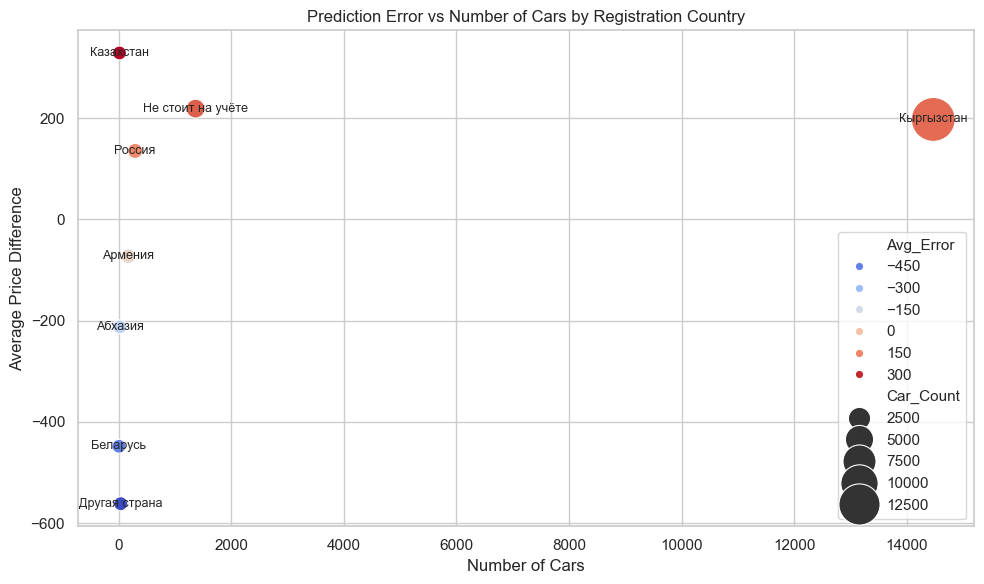

In [107]:
plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=registration_summary,
    x='Car_Count',
    y='Avg_Error',
    size='Car_Count',
    hue='Avg_Error',
    palette='coolwarm',
    sizes=(100, 1000),
    legend='brief'
)

for i in range(registration_summary.shape[0]):
    plt.text(
        x=registration_summary['Car_Count'][i],
        y=registration_summary['Avg_Error'][i],
        s=registration_summary['Registration_Country'][i],
        fontsize=9,
        ha='center',
        va='center'
    )

plt.title('Prediction Error vs Number of Cars by Registration Country')
plt.xlabel('Number of Cars')
plt.ylabel('Average Price Difference')
plt.grid(True)
plt.tight_layout()
plt.show()


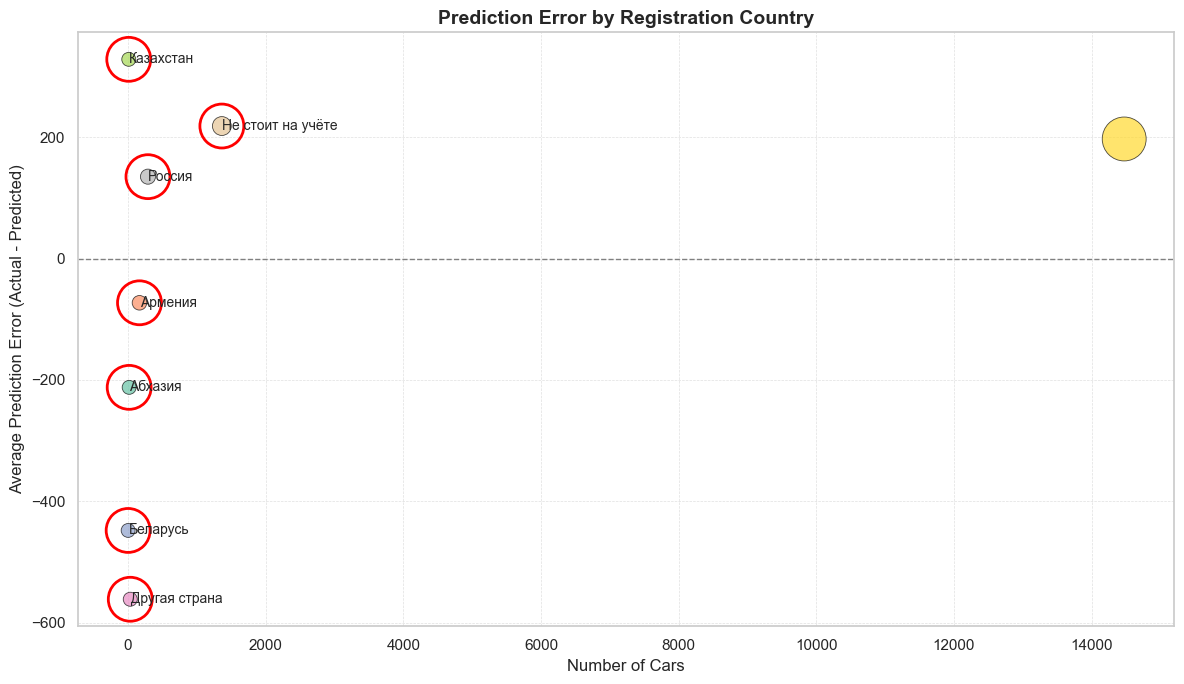

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 7))

# Main scatter plot
sns.scatterplot(
    data=registration_summary,
    x='Car_Count',
    y='Avg_Error',
    hue='Registration_Country',
    size='Car_Count',
    sizes=(100, 1000),
    palette='Set2',
    legend=False,
    edgecolor='black',
    linewidth=0.6,
    alpha=0.7
)

# Highlight non-Kyrgyzstan entries
highlight = registration_summary[registration_summary['Registration_Country'] != 'Кыргызстан']
for _, row in highlight.iterrows():
    plt.text(
        row['Car_Count'] + 5,
        row['Avg_Error'],
        row['Registration_Country'],
        fontsize=10,
        ha='left',
        va='center'
    )
    plt.scatter(
        row['Car_Count'],
        row['Avg_Error'],
        s=1000,
        facecolors='none',
        edgecolors='red',
        linewidths=2
    )

# Title and axis labels
plt.title('Prediction Error by Registration Country', fontsize=14, weight='bold')
plt.xlabel('Number of Cars', fontsize=12)
plt.ylabel('Average Prediction Error (Actual - Predicted)', fontsize=12)

# Axis and grid styling
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# Clean layout
plt.tight_layout()
plt.show()


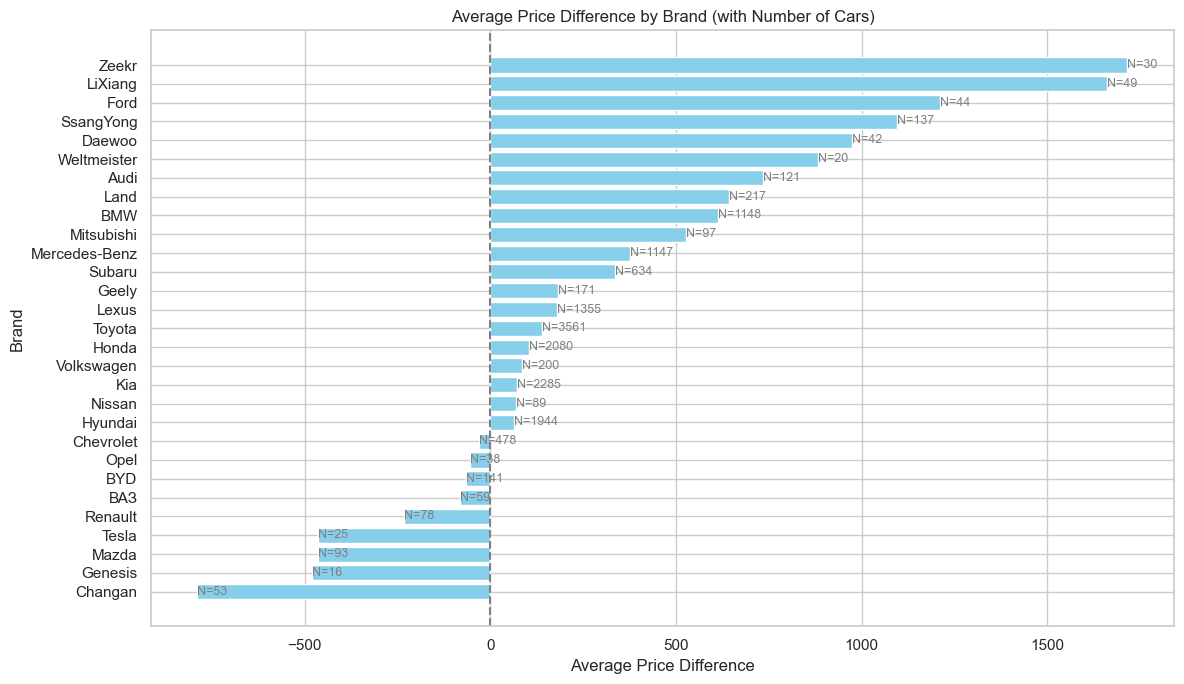

In [96]:
import matplotlib.pyplot as plt

# Step 1: Count number of cars per brand
brand_counts = y_train_f.groupby('Brand').size().reset_index(name='Car_Count')

# Step 2: Merge with the price difference DataFrame
brand_summary = brand_price_difference.merge(brand_counts, on='Brand')

# Step 3: Sort by Price_Difference for better visualization (optional)
brand_summary = brand_summary.sort_values(by='Price_Difference', ascending=True)

# Step 4: Plot
plt.figure(figsize=(12, 7))
bars = plt.barh(brand_summary['Brand'], brand_summary['Price_Difference'], color='skyblue')

# Add count labels to the bars
for bar, count in zip(bars, brand_summary['Car_Count']):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
             f'N={count}', va='center', ha='left', fontsize=9, color='gray')

plt.xlabel('Average Price Difference')
plt.ylabel('Brand')
plt.title('Average Price Difference by Brand (with Number of Cars)')
plt.axvline(x=0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()


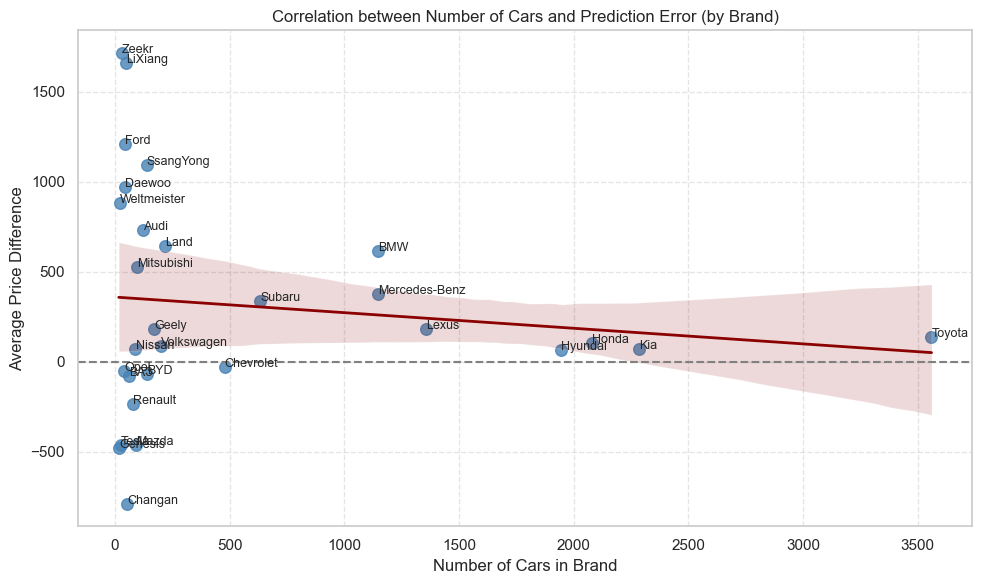

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure brand_summary is ready (already merged as before)

plt.figure(figsize=(10, 6))
sns.regplot(
    data=brand_summary,
    x='Car_Count',
    y='Price_Difference',
    scatter_kws={'s': 70, 'color': 'steelblue'},
    line_kws={'color': 'darkred', 'lw': 2}
)

# Add annotations for brand names
for i in range(len(brand_summary)):
    plt.text(
        brand_summary['Car_Count'].iloc[i] + 0.5,
        brand_summary['Price_Difference'].iloc[i],
        brand_summary['Brand'].iloc[i],
        fontsize=9
    )

plt.title('Correlation between Number of Cars and Prediction Error (by Brand)')
plt.xlabel('Number of Cars in Brand')
plt.ylabel('Average Price Difference')
plt.axhline(0, color='gray', linestyle='--')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


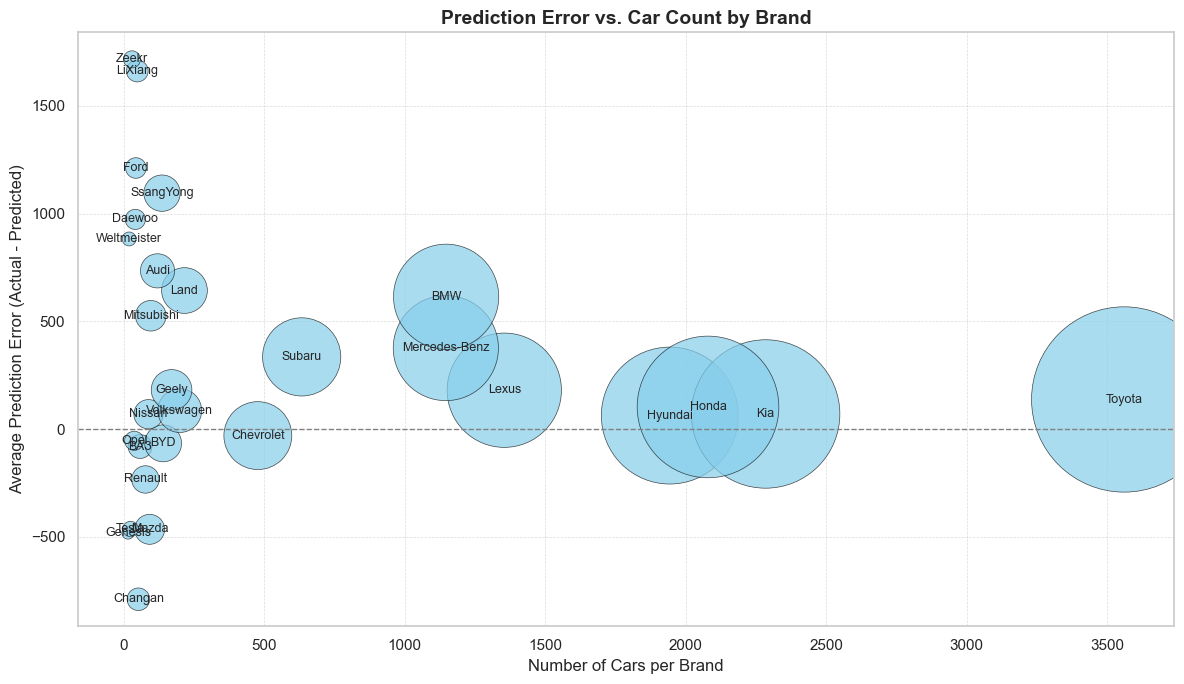

In [102]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))
plt.scatter(
    brand_summary['Car_Count'],
    brand_summary['Price_Difference'],
    s=brand_summary['Car_Count'] * 5,
    alpha=0.7,
    color='skyblue',
    edgecolors='black',
    linewidth=0.5
)

# Annotate each point
for i in range(len(brand_summary)):
    plt.text(
        brand_summary['Car_Count'].iloc[i],
        brand_summary['Price_Difference'].iloc[i],
        brand_summary['Brand'].iloc[i],
        fontsize=9,
        ha='center',
        va='center'
    )

# Add reference line and labels
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Axis labels and title
plt.title('Prediction Error vs. Car Count by Brand', fontsize=14, weight='bold')
plt.xlabel('Number of Cars per Brand', fontsize=12)
plt.ylabel('Average Prediction Error (Actual - Predicted)', fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()


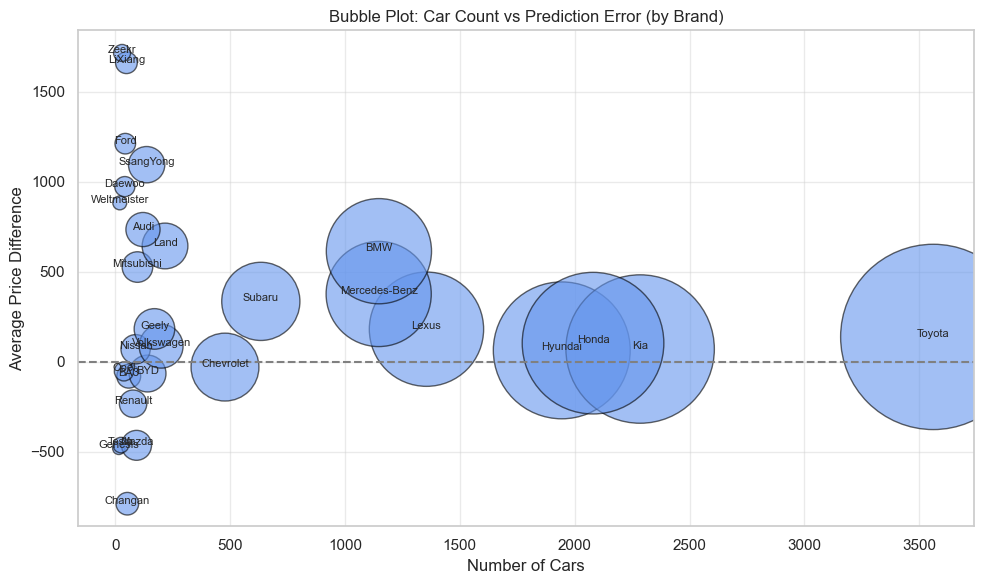

In [98]:
plt.figure(figsize=(10, 6))
plt.scatter(
    brand_summary['Car_Count'],
    brand_summary['Price_Difference'],
    s=brand_summary['Car_Count'] * 5,  # Bubble size proportional to number of cars
    alpha=0.6,
    color='cornflowerblue',
    edgecolors='black'
)

for i in range(len(brand_summary)):
    plt.text(
        brand_summary['Car_Count'].iloc[i],
        brand_summary['Price_Difference'].iloc[i],
        brand_summary['Brand'].iloc[i],
        fontsize=8,
        ha='center'
    )

plt.title('Bubble Plot: Car Count vs Prediction Error (by Brand)')
plt.xlabel('Number of Cars')
plt.ylabel('Average Price Difference')
plt.axhline(0, color='gray', linestyle='--')
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()


C:\Users\Burmachach.Nuradilov\AppData\Local\Temp\ipykernel_26856\1766945152.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


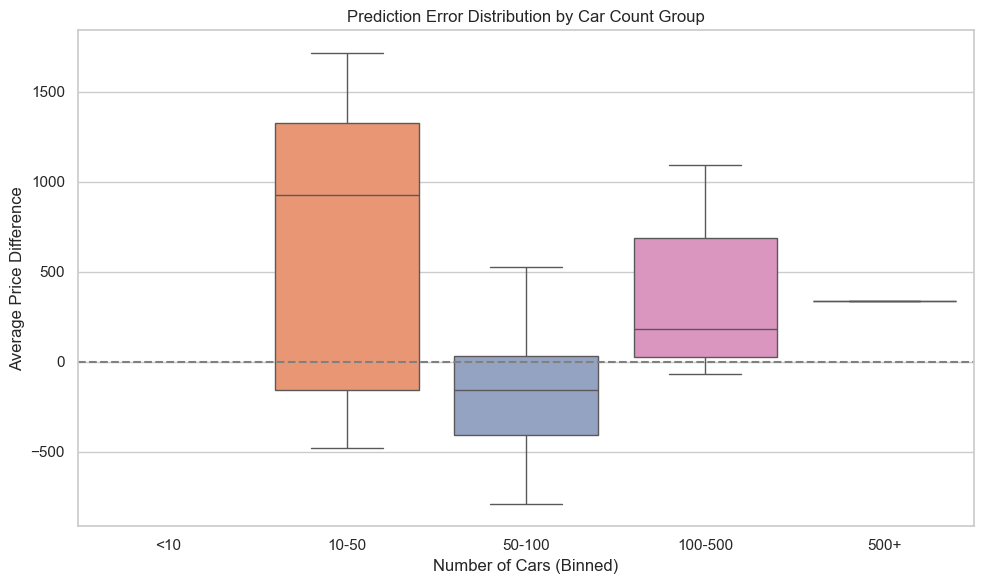

In [101]:
# Bin car counts
brand_summary['Car_Count_Bin'] = pd.cut(brand_summary['Car_Count'], bins=[0, 10, 50, 100, 500, 1000], labels=['<10', '10-50', '50-100', '100-500', '500+'])

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=brand_summary,
    x='Car_Count_Bin',
    y='Price_Difference',
    palette='Set2'
)

plt.title('Prediction Error Distribution by Car Count Group')
plt.xlabel('Number of Cars (Binned)')
plt.ylabel('Average Price Difference')
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()


C:\Users\Burmachach.Nuradilov\AppData\Local\Temp\ipykernel_26856\3303096114.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


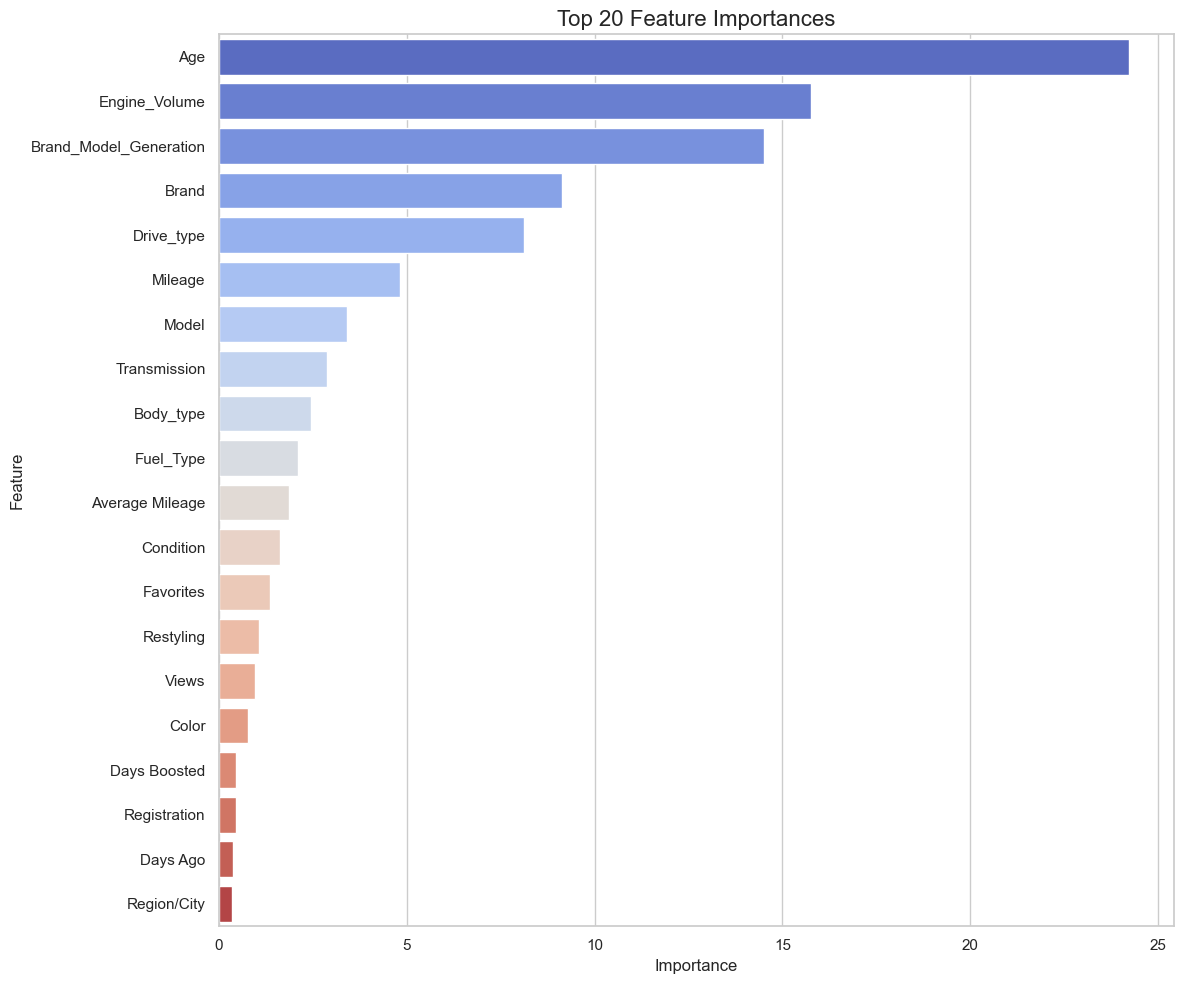

Feature  Importance
70                     age   24.207692
21           Engine_Volume   15.750169
17  Brand_Model_Generation   14.507078
14                   Brand    9.128396
6               Drive_type    8.129074
2                  Mileage    4.819087
15                   Model    3.424371
5             Transmission    2.876973
3                Body_type    2.460989
20               Fuel_Type    2.112339
71         average_mileage    1.866216
8                Condition    1.636211
1                Favorites    1.354845
16               Restyling    1.067589
0                    Views    0.969230
4                     Цвет    0.771690
19              Upped_days    0.465538
11            Registration    0.447956
18                Days_Ago    0.385597
10             Region_city    0.345037

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Create the DataFrame
data = {
    'Feature': [
        'age', 'Engine_Volume', 'Brand_Model_Generation', 'Brand', 'Drive_type', 'Mileage',
        'Model', 'Transmission', 'Body_type', 'Fuel_Type', 'average_mileage', 'Condition',
        'Favorites', 'Restyling', 'Views', 'Цвет', 'Upped_days', 'Registration',
        'Days_Ago', 'Region_city'
    ],
    'Importance': [
        24.207692, 15.750169, 14.507078, 9.128396, 8.129074, 4.819087,
        3.424371, 2.876973, 2.460989, 2.112339, 1.866216, 1.636211,
        1.354845, 1.067589, 0.969230, 0.771690, 0.465538, 0.447956,
        0.385597, 0.345037
    ]
}

df = pd.DataFrame(data)

# Step 2: Translate Russian features
translations = {
    'age':'Age',
    'Цвет': 'Color',
    'Region_city': 'Region/City',
    'Upped_days': 'Days Boosted',
    'Days_Ago': 'Days Ago',
    'Registration': 'Registration',
    'average_mileage':'Average Mileage'
}

df['Feature'] = df['Feature'].replace(translations)

# Step 3: Plot
plt.figure(figsize=(12, 10))
sns.set(style="whitegrid")

sns.barplot(
    data=df.sort_values(by='Importance', ascending=False),
    y='Feature',
    x='Importance',
    palette='coolwarm'
)

plt.title('Top 20 Feature Importances', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()
top_features

C:\Users\Burmachach.Nuradilov\AppData\Local\Temp\ipykernel_26856\730974899.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


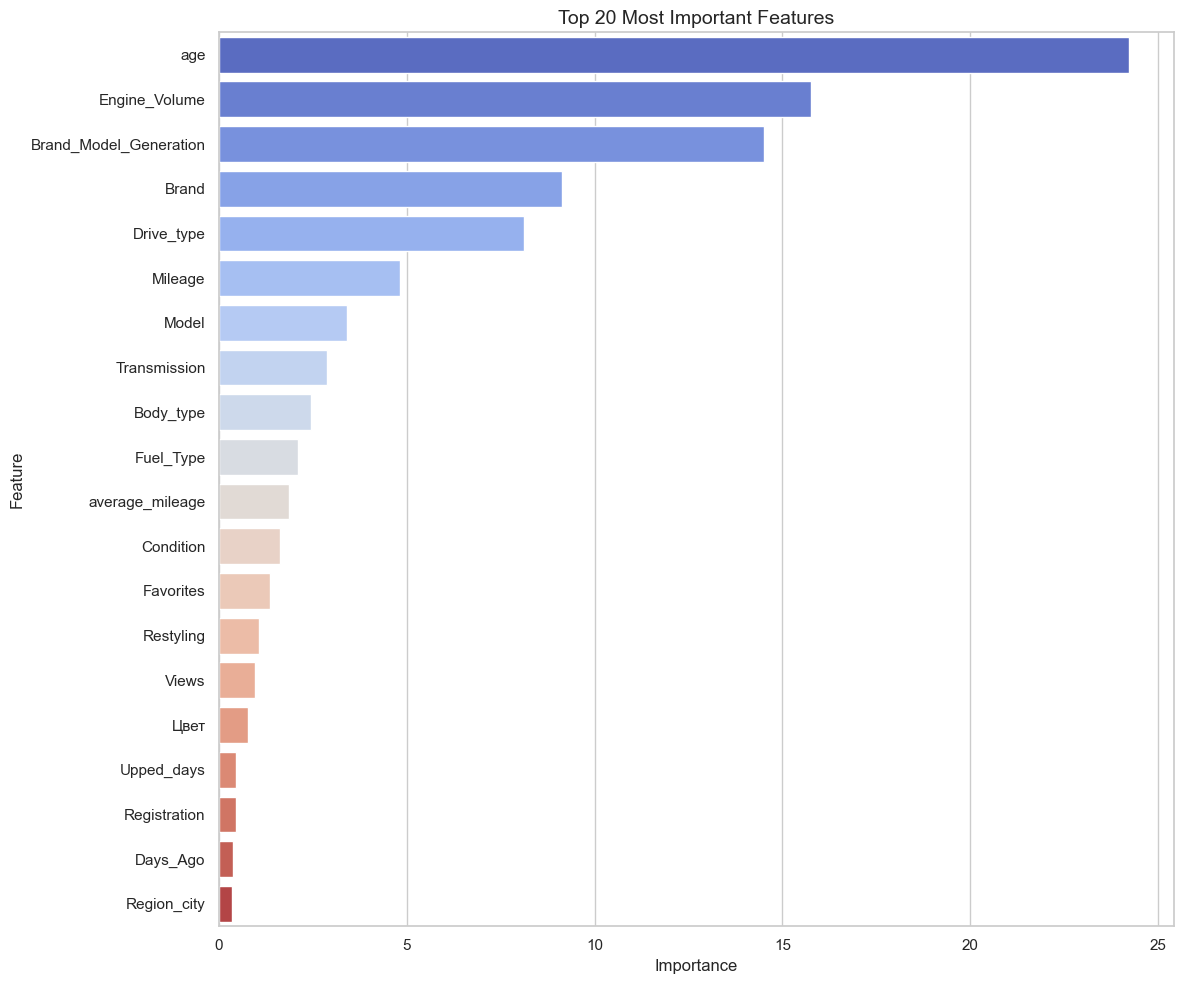

In [64]:
feature_importances = model.get_feature_importance()
feature_names = X.columns

feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Select top 30 features
top_features = feat_imp_df.head(20)

# Set style
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(12, 10))
sns.barplot(
    data=top_features,
    y='Feature',
    x='Importance',
    palette='coolwarm'
)

# Add labels and title
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 20 Most Important Features', fontsize=14)
plt.tight_layout()
plt.show()

In [58]:
df_noyearcatyear['Price_D'].min()

4530

In [72]:
df_results = pd.DataFrame({
    'Цена': np.expm1(y_test),
    'Predicted_Price': y_test_pred
})

# Ensure the DataFrame is sorted or indexed correctly
df_results.reset_index(drop=True, inplace=True)
bins = [4500, 10000, 20000, 40000, 60000, 80000, 100000,  120000]
labels = ['4.5-10k', '10-20k',  '20-40k',  '40-60k',  '60-80k', '80-100k', '100-120k']

# Create custom bins using pd.cut
df_results['Price_Bin'] = pd.cut(df_results['Цена'], bins=bins, labels=labels, right=False)
def calculate_errors(group):
    mae = np.mean(np.abs(group['Цена'] - group['Predicted_Price']))
    rmse = np.sqrt(np.mean((group['Цена'] - group['Predicted_Price'])**2))
    mape = np.mean(np.abs((group['Цена'] - group['Predicted_Price']) / group['Цена'])) * 100
    return pd.Series({'MAE': mae, 'RMSE': rmse, 'MAPE': mape})

# Apply the function to each bin
error_metrics = df_results.groupby('Price_Bin').apply(calculate_errors).reset_index()

error_metrics

C:\Users\Burmachach.Nuradilov\AppData\Local\Temp\ipykernel_26856\4272145938.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_metrics = df_results.groupby('Price_Bin').apply(calculate_errors).reset_index()
C:\Users\Burmachach.Nuradilov\AppData\Local\Temp\ipykernel_26856\4272145938.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  error_metrics = df_results.groupby('Price_Bin').apply(calculate_errors).reset_index()


Price_Bin           MAE          RMSE       MAPE
0   4.5-10k    695.403290   1028.238622  10.222048
1    10-20k   1201.655160   1703.477838   8.314218
2    20-40k   2837.904617   4023.817577  10.168089
3    40-60k   5295.702617   6998.235330  10.731699
4    60-80k   8861.736417  10663.244013  12.998545
5   80-100k  12744.802455  16300.290630  14.658220
6  100-120k  16653.148921  18216.802435  15.297554

In [73]:
# Assuming df_results has 'Цена' and 'Predicted_Price' and you have the 'brand' column in the original dataset

# Add the 'brand' column to df_results (ensure you align the data properly with y_test or indices)
df_results['brand'] = df_noyearcatyear['Brand'].iloc[y_test.index].values

# Now you can visualize or summarize the results by brand
import seaborn as sns
import matplotlib.pyplot as plt

# Box plot of predicted prices per brand
plt.figure(figsize=(12, 6))
sns.boxplot(x='brand', y='Predicted_Price', data=df_results)
plt.title('Model Predictions by Brand')
plt.xlabel('Car Brand')
plt.ylabel('Predicted Price')
plt.xticks(rotation=90)
plt.show()

# Or a simple summary table
brand_predictions = df_results.groupby('brand').agg({'Predicted_Price': ['mean', 'std', 'min', 'max']})
print(brand_predictions)


IndexError: positional indexers are out-of-bounds

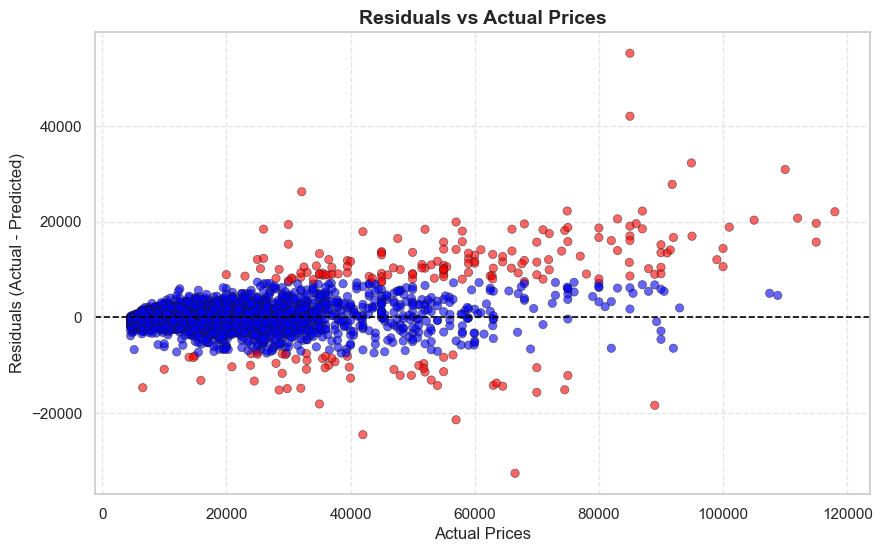

In [60]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate residuals
residuals = np.expm1(y_test) - y_test_pred
actual_prices = np.expm1(y_test)

# Define threshold for large residuals (e.g., top 10% of absolute residuals)
threshold = np.percentile(np.abs(residuals), 95)

# Create color labels: Red for large residuals, Blue for others
colors = np.where(np.abs(residuals) > threshold, 'red', 'blue')

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(actual_prices, residuals, c=colors, alpha=0.6, edgecolors='k', linewidth=0.5)

# Highlight horizontal zero line
plt.axhline(0, color='black', linestyle='--', linewidth=1.2)

# Titles and labels
plt.title("Residuals vs Actual Prices", fontsize=14, fontweight='bold')
plt.xlabel("Actual Prices", fontsize=12)
plt.ylabel("Residuals (Actual - Predicted)", fontsize=12)

# Improve grid visibility
plt.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.show()


0:	learn: 0.6287135	test: 0.6278884	test1: 0.6271048	best: 0.6271048 (0)	total: 105ms	remaining: 1m 45s
100:	learn: 0.1618847	test: 0.1561110	test1: 0.1683038	best: 0.1683038 (100)	total: 9.43s	remaining: 1m 23s
200:	learn: 0.1433717	test: 0.1400600	test1: 0.1563318	best: 0.1563318 (200)	total: 19.6s	remaining: 1m 17s
300:	learn: 0.1308265	test: 0.1296280	test1: 0.1500191	best: 0.1500191 (300)	total: 30.6s	remaining: 1m 11s
400:	learn: 0.1222050	test: 0.1230198	test1: 0.1462140	best: 0.1462140 (400)	total: 41.7s	remaining: 1m 2s
500:	learn: 0.1160045	test: 0.1181644	test1: 0.1444148	best: 0.1444148 (500)	total: 52.5s	remaining: 52.3s
600:	learn: 0.1103214	test: 0.1142211	test1: 0.1432109	best: 0.1432034 (599)	total: 1m 3s	remaining: 42.1s
700:	learn: 0.1057431	test: 0.1110443	test1: 0.1419049	best: 0.1419049 (700)	total: 1m 14s	remaining: 31.7s
800:	learn: 0.1010134	test: 0.1077151	test1: 0.1411373	best: 0.1411002 (796)	total: 1m 23s	remaining: 20.8s
900:	learn: 0.0972556	test: 0.10510

C:\Users\Burmachach.Nuradilov\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Burmachach.Nuradilov\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


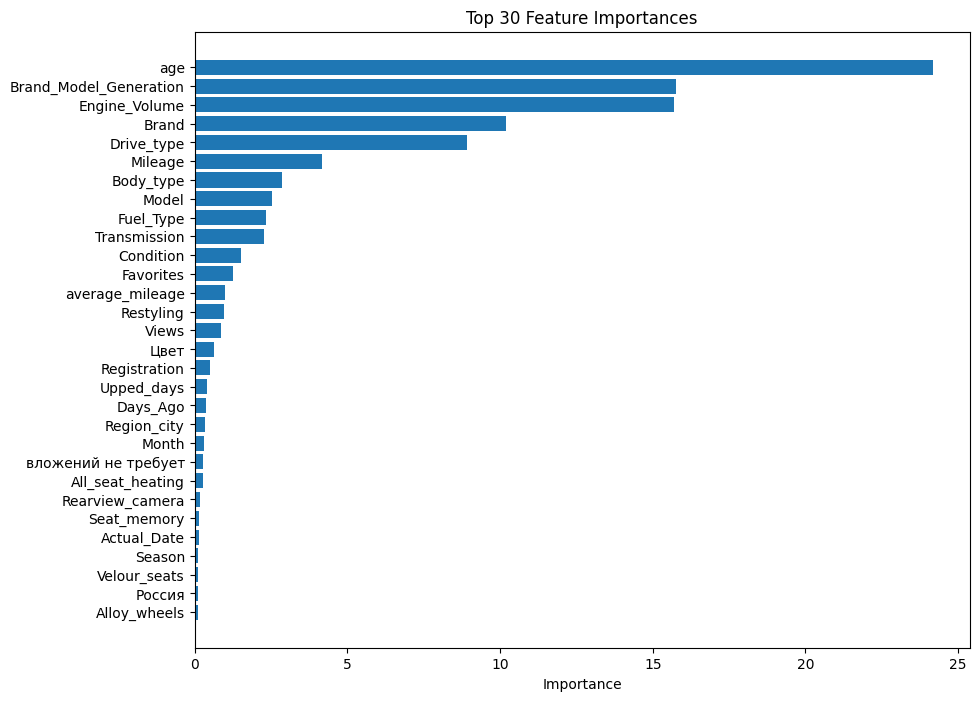

In [136]:
X = df_noyearcatyear.drop(columns=['Price_D'])  # Features
y = df_noyearcatyear['Price_D']  # Target

# Apply log transformation to the target variable
y_log = np.log1p(y)  # Log transformation (log(x + 1))

# Identify categorical columns by their indices
categorical_columns = [
    X.columns.get_loc(col) 
    for col in X.select_dtypes(include=['object', 'category']).columns
]

# Step 2: Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42  # Use y_log for training
)

# Step 3: Initialize and train CatBoost with categorical features
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=8,
    l2_leaf_reg=10,
    bagging_temperature=0.7944641961311574,
    cat_features=categorical_columns,
    random_seed=42,
    verbose=100,
    border_count=50
)

model.fit(
    X_train, 
    y_train, 
    eval_set=[(X_train, y_train), (X_test, y_test)],  # Track train and test scores
    use_best_model=True,
    early_stopping_rounds=50,  # Early stopping
    verbose=100
)

# Predict on training and test sets (log-transformed values)
y_train_pred_log = model.predict(X_train)
y_test_pred_log = model.predict(X_test)

# Reverse log transformation (since we used log1p transformation)
y_train_pred = np.expm1(y_train_pred_log)  # Reverse the transformation on predictions
y_test_pred = np.expm1(y_test_pred_log)  # Reverse the transformation on predictions

# Compute metrics for training data
train_mae = mean_absolute_error(np.expm1(y_train), y_train_pred)  # Reverse log on original y_train
train_rmse = mean_squared_error(np.expm1(y_train), y_train_pred, squared=False)
train_r2 = r2_score(np.expm1(y_train), y_train_pred)
train_mape = mean_absolute_percentage_error(np.expm1(y_train), y_train_pred) * 100
train_median_ae = median_absolute_error(np.expm1(y_train), y_train_pred)
train_explained_var = explained_variance_score(np.expm1(y_train), y_train_pred)

# Compute metrics for test data
test_mae = mean_absolute_error(np.expm1(y_test), y_test_pred)  # Reverse log on original y_test
test_rmse = mean_squared_error(np.expm1(y_test), y_test_pred, squared=False)
test_r2 = r2_score(np.expm1(y_test), y_test_pred)
test_mape = mean_absolute_percentage_error(np.expm1(y_test), y_test_pred) * 100
test_median_ae = median_absolute_error(np.expm1(y_test), y_test_pred)
test_explained_var = explained_variance_score(np.expm1(y_test), y_test_pred)

# Display the results
print("\n📌 Model Performance Metrics:\n")
print(f"🔹 Train Data:")
print(f"   - MAE: {train_mae:.2f}")
print(f"   - RMSE: {train_rmse:.2f}")
print(f"   - R² Score: {train_r2:.4f}")
print(f"   - MAPE: {train_mape:.2f}%")
print(f"   - Median Absolute Error: {train_median_ae:.2f}")
print(f"   - Explained Variance Score: {train_explained_var:.4f}\n")

print(f"🔹 Test Data:")
print(f"   - MAE: {test_mae:.2f}")
print(f"   - RMSE: {test_rmse:.2f}")
print(f"   - R² Score: {test_r2:.4f}")
print(f"   - MAPE: {test_mape:.2f}%")
print(f"   - Median Absolute Error: {test_median_ae:.2f}")
print(f"   - Explained Variance Score: {test_explained_var:.4f}")

# Feature Importance Visualization
feature_importances = model.get_feature_importance()
feature_names = X.columns

feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(feat_imp_df['Feature'][:30][::-1], feat_imp_df['Importance'][:30][::-1])
plt.xlabel('Importance')
plt.title('Top 30 Feature Importances')
plt.show()

In [49]:
df_noyearcatyear.groupby('Condition')[['Price_D', 'Mileage']].mean()

Price_D        Mileage
Condition                             
идеальное  22922.760909  147396.906369
новое      39717.449242   13841.807468
хорошее    15337.965288  199598.528273

In [140]:
df_nobins = df.drop(columns=['Price_Bin'])

In [139]:
df.head()

Views  Favorites  Year_of_manufacture  Mileage          Body_type  \
0    375          1                 2022    55000              седан   
1    674         15                 2011   250000  внедорожник 5 дв.   
2    318          2                 2019    64373  внедорожник 5 дв.   
3    709         11                 2006   280000              седан   
4    147          2                 2018   124000              седан   

         Цвет Transmission Drive_type Steering_wheel_position  Condition  \
0      черный      автомат   передний                   слева  идеальное   
1      черный     вариатор     полный                   слева  идеальное   
2       белый      автомат     полный                   слева  идеальное   
3  коричневый      автомат   передний                   слева    хорошее   
4      черный      автомат   передний                   слева  идеальное   

  Customs_clearance Region_city Registration     Exchange_option  \
0        растаможен      Бишкек   Кыргызстан  рассмотрю варианты   
1        растаможен      Бишкек   Кыргызстан  рассмотрю варианты   
2        растаможен      Бишкек   Кыргызстан  рассмотрю варианты   
3        растаможен      Бишкек   Кыргызстан  рассмотрю варианты   
4        растаможен      Бишкек   Кыргызстан  рассмотрю варианты   

  Installment_option    Brand       Model  Restyling  \
0                нет   Toyota       Camry       True   
1                нет   Toyota  Highlander       True   
2                нет      Kia    Sportage       True   
3                нет    Honda       Civic      False   
4                нет  Hyundai      Sonata       True   

       Brand_Model_Generation  Days_Ago  Upped_days Fuel_Type  Engine_Volume  \
0    Toyota Camry VIII (XV70)        24           9    бензин            3.5   
1  Toyota Highlander II (U40)        66          66    гибрид            3.5   
2             Kia Sportage IV        66          66    бензин            2.4   
3            Honda Civic VIII        66          66    бензин            1.8   
4     Hyundai Sonata VII (LF)        66          66    бензин            2.4   

           Actual_Date     Month  Season  Price_D  полный электропакет  \
0  2024-12-14 12:32:00  December  Winter    32000                    1   
1  2024-11-02 12:33:00  November  Autumn    18500                    1   
2  2024-11-02 12:33:00  November  Autumn    14200                    0   
3  2024-11-02 12:33:00  November  Autumn     4800                    0   
4  2024-11-02 12:33:00  November  Autumn    11900                    0   

   Alarm_system  Remote_start  Air_conditioner  Climate_control  \
0             1             0                1                1   
1             0             0                1                1   
2             0             0                0                0   
3             0             0                0                0   
4             1             0                1                1   

   газобалонное оборудование  круиз-контроль  Front_seat_heating  \
0                          0               0                   0   
1                          0               0                   1   
2                          0               0                   0   
3                          0               0                   0   
4                          0               0                   1   

   All_seat_heating  обогрев зеркал  Xenon_headlights  Bi_xenon_headlights  \
0                 1               0                 0                    0   
1                 0               0                 0                    0   
2                 0               0                 0                    0   
3                 0               0                 0                    0   
4                 0               0                 0                    0   

   Headlight_washer  Air_suspension  Seat_memory  Steering_wheel_memory  \
0                 0               0            0                      0   
1         

In [54]:
df_noyearcatyear['Price_D'].max()

119000

In [50]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


# Separate features and target
X = df_noyearcatyear.drop(columns=["Price_D"])
y = df_noyearcatyear["Price_D"]

# Encode categorical features
categorical_columns = X.select_dtypes(include=["object"]).columns
for col in categorical_columns:
    encoder = LabelEncoder()
    X[col] = encoder.fit_transform(X[col])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
models = {
    # "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor( random_state=42, max_depth=30, min_samples_leaf= 1, min_samples_split=2, n_estimators=200),
    # "Gaussian Process": GaussianProcessRegressor(kernel=RBF(length_scale=1.0))
    # "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100 
    results[name] = {"MSE": mse, "R2": r2, "RMSE":rmse, "MAPE": mape}

    print(f"{name}:\n  Mean Squared Error: {mse:.2f}\n  R2 Score: {r2:.2f}\n")

# Convert results to DataFrame
results_df = pd.DataFrame(results).T

# Display results
print("\nModel Performance:")
print(results_df)


Random Forest:
  Mean Squared Error: 17815091.56
  R2 Score: 0.93


Model Performance:
                        MSE        R2         RMSE      MAPE
Random Forest  1.781509e+07  0.930583  4220.792765  11.80073


In [142]:
mae = mean_absolute_error(y_test, y_pred)
mae

3354.6863829331496

C:\Users\Burmachach.Nuradilov\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


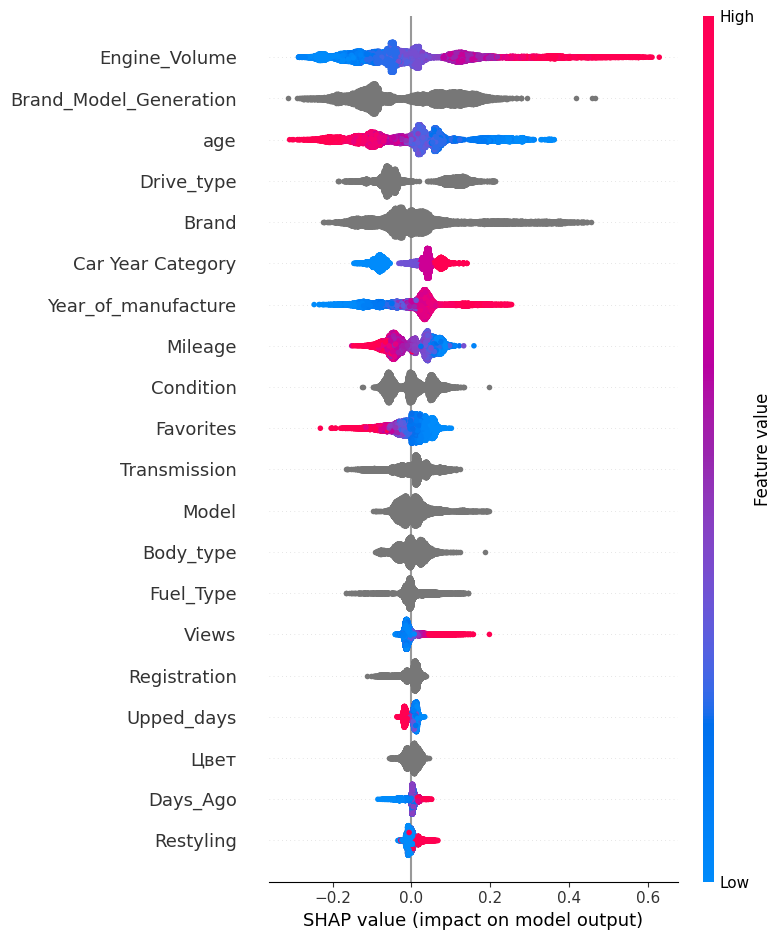

In [56]:
import shap
import matplotlib.pyplot as plt

# Assuming you have a trained model and data (X_train, model)

# Create a SHAP explainer object for a tree-based model
explainer = shap.TreeExplainer(model)  # Replace with your model (e.g., XGBoost, LightGBM, etc.)

# Compute SHAP values for the dataset
shap_values = explainer.shap_values(X_train)

# Plot SHAP summary plot with dots showing positive or negative impact
shap.summary_plot(shap_values, X_train) 

C:\Users\Burmachach.Nuradilov\AppData\Local\Temp\ipykernel_20460\4212465448.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


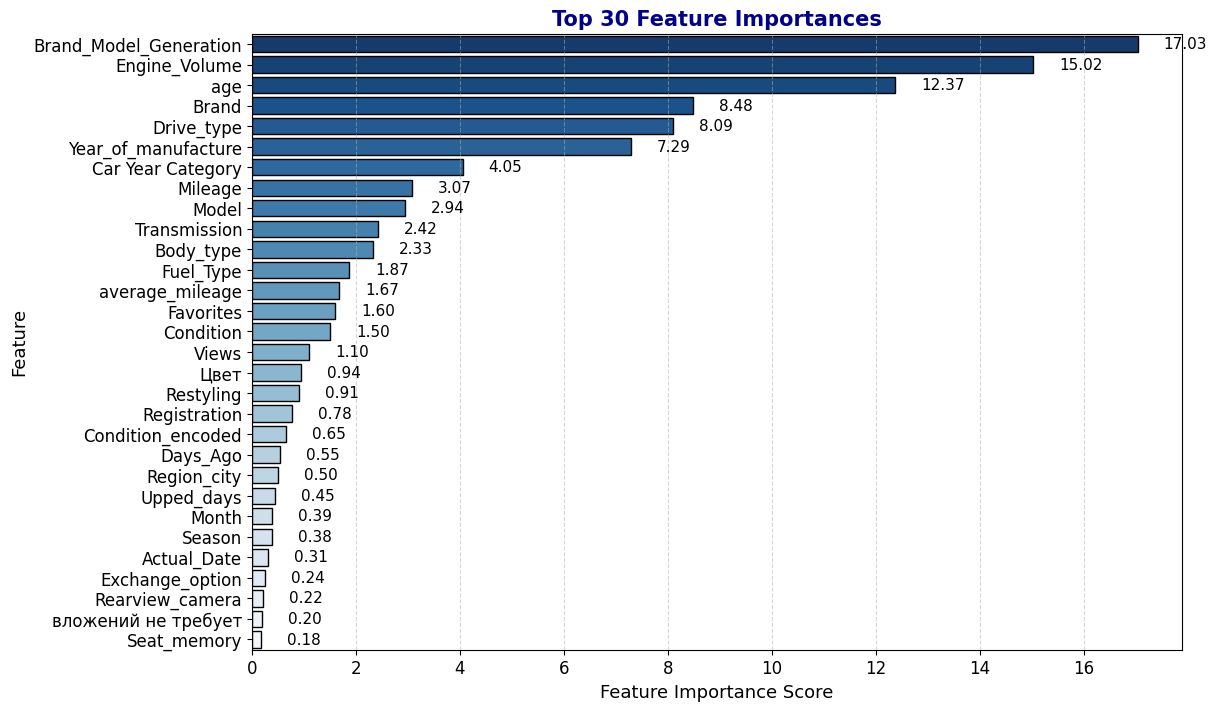

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances from the trained CatBoost model
feature_importances = model.get_feature_importance()
feature_names = X.columns

# Create a DataFrame for better visualization
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Select the top 30 features
top_n = 30
top_features = feat_imp_df.head(top_n)

# Visualization
plt.figure(figsize=(12, 8))
sns.barplot(
    x=top_features['Importance'], 
    y=top_features['Feature'], 
    palette='Blues_r',  # Gradient color from dark to light
    edgecolor='black'
)

# Add labels on bars
for index, value in enumerate(top_features['Importance']):
    plt.text(value + 0.5, index, f"{value:.2f}", va='center', fontsize=11, color='black')

# Formatting
plt.xlabel('Feature Importance Score', fontsize=13, color='black')
plt.ylabel('Feature', fontsize=13, color='black')
plt.title(f'Top {top_n} Feature Importances', fontsize=15, fontweight='bold', color='darkblue')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()


C:\Users\Burmachach.Nuradilov\AppData\Local\Temp\ipykernel_26856\2506907003.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\Burmachach.Nuradilov\AppData\Local\Temp\ipykernel_26856\2506907003.py:25: UserWarning: The palette list has more values (30) than needed (20), which may not be intended.
  sns.barplot(


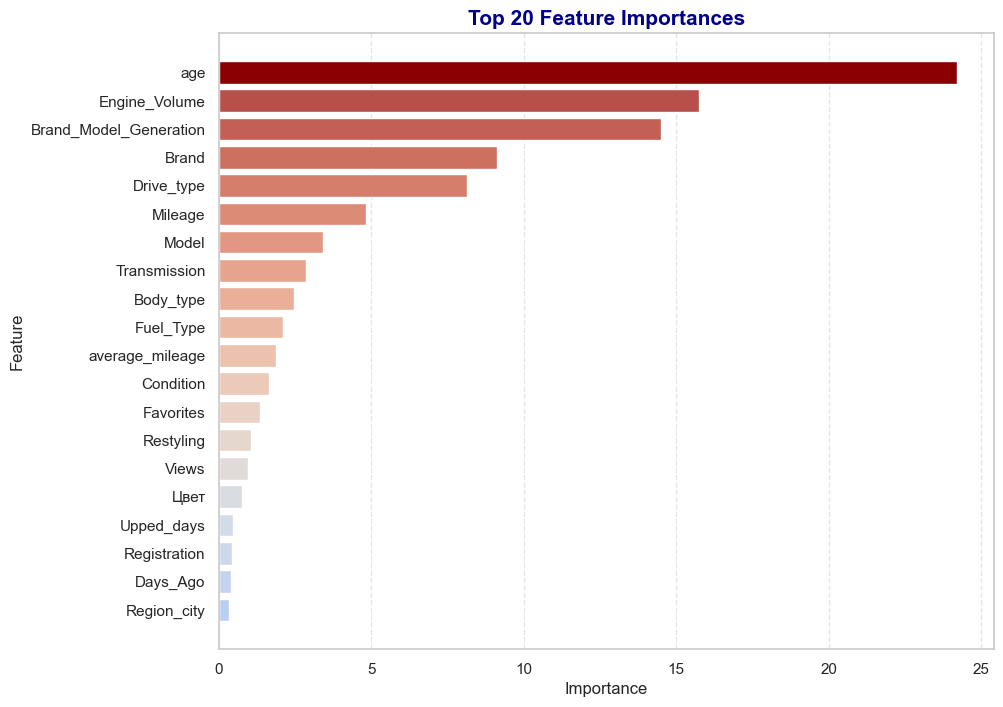

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importance values
feature_importances = model.get_feature_importance()
feature_names = X.columns

# Create a DataFrame
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display the table (sorted, rounded)
feat_imp_df['Importance'] = feat_imp_df['Importance'].round(3)  # Round values
# print(feat_imp_df.head(30))  # Print top 30 for quick view

# --- 📊 Enhanced Visualization ---
plt.figure(figsize=(10, 8))

# Use color gradient based on importance
colors = sns.color_palette("coolwarm", len(feat_imp_df[:30]))

sns.barplot(
    y=feat_imp_df['Feature'][:20], 
    x=feat_imp_df['Importance'][:20], 
    palette=colors[::-1]
)
# Add labels on bars



# Highlight the most important feature
plt.barh(feat_imp_df['Feature'].iloc[0], feat_imp_df['Importance'].iloc[0], color='darkred')

# Labels & Title
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 20 Feature Importances', fontsize=15, fontweight='bold', color='darkblue')

# Improve readability
plt.grid(axis='x', linestyle='--', alpha=0.5)
# plt.gca().invert_yaxis()  # Keep the most important feature on top

# Show the plot
plt.show()


In [96]:
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score, 
    mean_absolute_percentage_error, median_absolute_error, explained_variance_score
)

# Prepare the features and target
X = df_small.drop(columns=['Price_D'])  # Features
y = df_small['Price_D']  # Target

# Apply log transformation to the target variable
y_log = np.log1p(y)  # Log transformation (log(x + 1))

# Identify categorical columns by their indices
categorical_columns = [
    X.columns.get_loc(col) 
    for col in X.select_dtypes(include=['object', 'category']).columns
]

# Step 2: Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42  # Use y_log for training
)
# learning_rate': 0.1, 'l2_leaf_reg': 2, 'iterations': 1000, 'depth': 8, 'border_count': 50
# Step 3: Initialize and train CatBoost with categorical features
model = CatBoostRegressor(
    # iterations=1000,
    # learning_rate=0.13673617656361287,
    # depth=8,
    # l2_leaf_reg=2.3358152187917005,
    # bagging_temperature=0.7944641961311574,
    # cat_features=categorical_columns,
    # random_seed=42,
    # verbose=100
    iterations=1000,
    learning_rate=0.1,
    depth=8,
    l2_leaf_reg=2,
    bagging_temperature=0.7944641961311574,
    cat_features=categorical_columns,
    random_seed=42,
    verbose=100,
    border_count=50
)

model.fit(
    X_train, 
    y_train, 
    eval_set=[(X_train, y_train), (X_test, y_test)],  # Track train and test scores
    use_best_model=True,
    early_stopping_rounds=50,
    verbose=100
)

# Predict on training and test sets (log-transformed values)
y_train_pred_log = model.predict(X_train)
y_test_pred_log = model.predict(X_test)

# Reverse log transformation (since we used log1p transformation)
y_train_pred = np.expm1(y_train_pred_log)
y_test_pred = np.expm1(y_test)

# Compute metrics for training data
train_mae = mean_absolute_error(np.expm1(y_train), y_train_pred)
train_rmse = mean_squared_error(np.expm1(y_train), y_train_pred, squared=False)
train_r2 = r2_score(np.expm1(y_train), y_train_pred)
train_mape = mean_absolute_percentage_error(np.expm1(y_train), y_train_pred) * 100
train_median_ae = median_absolute_error(np.expm1(y_train), y_train_pred)
train_explained_var = explained_variance_score(np.expm1(y_train), y_train_pred)

# Compute metrics for test data
test_mae = mean_absolute_error(np.expm1(y_test), y_test_pred)
test_rmse = mean_squared_error(np.expm1(y_test), y_test_pred, squared=False)
test_r2 = r2_score(np.expm1(y_test), y_test_pred)
test_mape = mean_absolute_percentage_error(np.expm1(y_test), y_test_pred) * 100
test_median_ae = median_absolute_error(np.expm1(y_test), y_test_pred)
test_explained_var = explained_variance_score(np.expm1(y_test), y_test_pred)

# Display the results
print("\n📌 Model Performance Metrics:\n")
print(f"🔹 Train Data:")
print(f"   - MAE: {train_mae:.2f}")
print(f"   - RMSE: {train_rmse:.2f}")
print(f"   - R² Score: {train_r2:.4f}")
print(f"   - MAPE: {train_mape:.2f}%")
print(f"   - Median Absolute Error: {train_median_ae:.2f}")
print(f"   - Explained Variance Score: {train_explained_var:.4f}\n")

print(f"🔹 Test Data:")
print(f"   - MAE: {test_mae:.2f}")
print(f"   - RMSE: {test_rmse:.2f}")
print(f"   - R² Score: {test_r2:.4f}")
print(f"   - MAPE: {test_mape:.2f}%")
print(f"   - Median Absolute Error: {test_median_ae:.2f}")
print(f"   - Explained Variance Score: {test_explained_var:.4f}")

# Display the results
# print(f"Mean Absolute Error (MAE): {mae:.2f}")
# print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
# print(f"R² Score: {r2:.4f}")
# print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
# print(f"Median Absolute Error: {median_ae:.2f}")
# print(f"Explained Variance Score: {explained_var:.4f}")

# Feature Importance Visualization
feature_importances = model.get_feature_importance()
feature_names = X.columns

feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(feat_imp_df['Feature'][:30][::-1], feat_imp_df['Importance'][:30][::-1])
plt.xlabel('Importance')
plt.title('Top 30 Feature Importances')
plt.show()


NameError: name 'df_small' is not defined

OTHER MODELS

In [97]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.neural_network import MLPRegressor

Mean Absolute Error (MAE): 2860.53
Root Mean Squared Error (RMSE): 5835.22
R² Score: 0.8708
Mean Absolute Percentage Error (MAPE): 14.32%
Median Absolute Error: 1300.00
Explained Variance Score: 0.8710


C:\Users\Burmachach.Nuradilov\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


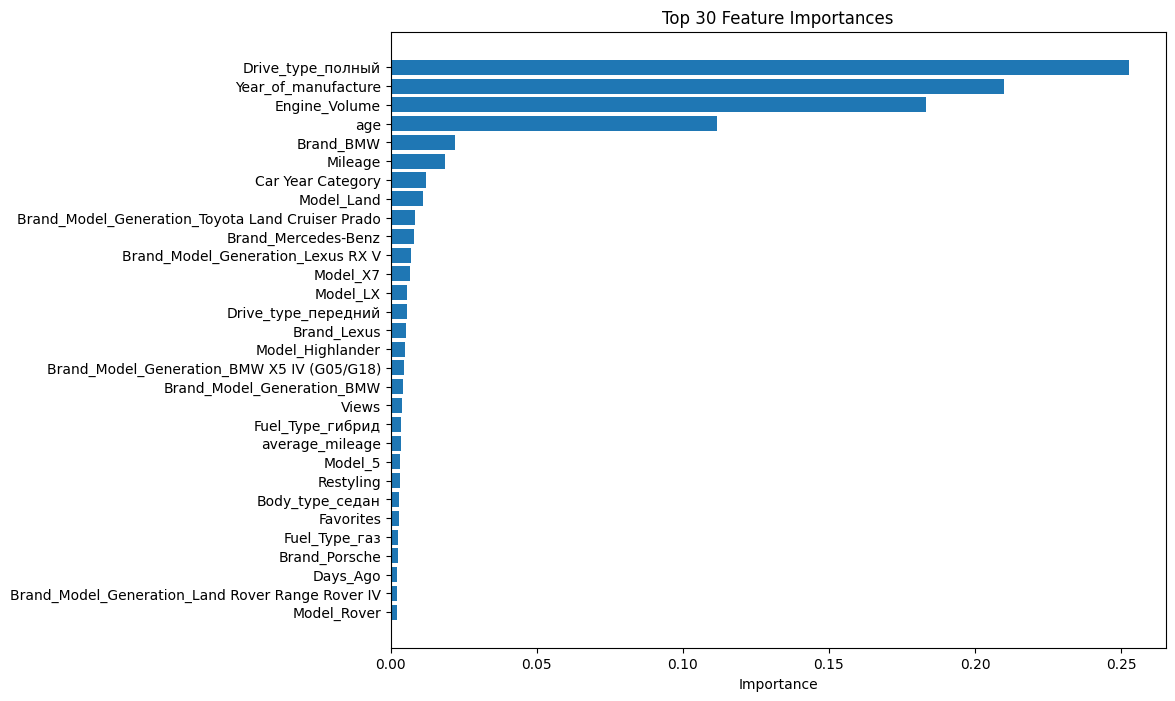

In [95]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score, 
    mean_absolute_percentage_error, median_absolute_error, explained_variance_score
)
import pandas as pd
import matplotlib.pyplot as plt

X = df.drop(columns=['Price_D'])  # Features
y = df['Price_D']  # Target

# Identify categorical columns
categorical_columns = X.select_dtypes(include=['object', 'category']).columns

# Encoding categorical features using one-hot encoding
X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

# Step 2: Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Step 3: Initialize and train Decision Tree Regressor
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

# Step 4: Evaluate the model
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # Convert to percentage
median_ae = median_absolute_error(y_test, y_pred)
explained_var = explained_variance_score(y_test, y_pred)

# Display the results
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Median Absolute Error: {median_ae:.2f}")
print(f"Explained Variance Score: {explained_var:.4f}")

# Feature Importance Visualization
feature_importances = model.feature_importances_
feature_names = X.columns

feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(feat_imp_df['Feature'][:30][::-1], feat_imp_df['Importance'][:30][::-1])
plt.xlabel('Importance')
plt.title('Top 30 Feature Importances')
plt.show()


C:\Users\Burmachach.Nuradilov\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Mean Absolute Error (MAE): 3955.81
Root Mean Squared Error (RMSE): 6538.53
R² Score: 0.8378
Mean Absolute Percentage Error (MAPE): 25.98%
Median Absolute Error: 2372.10
Explained Variance Score: 0.8378


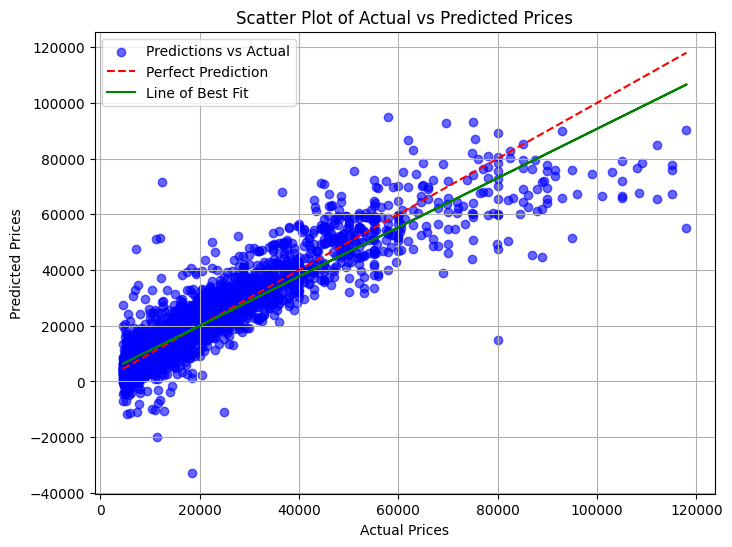

In [98]:
# Step 3: Initialize and train Decision Tree Regressor
model = PLSRegression(n_components = 20)
model.fit(X_train, y_train)

# Step 4: Evaluate the model
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # Convert to percentage
median_ae = median_absolute_error(y_test, y_pred)
explained_var = explained_variance_score(y_test, y_pred)

# Display the results
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Median Absolute Error: {median_ae:.2f}")
print(f"Explained Variance Score: {explained_var:.4f}")

plt.figure(figsize=(8, 6))

# Scatter plot: Actual vs Predicted
plt.scatter(y_test, y_pred, alpha=0.6, label='Predictions vs Actual', color='blue')

# Add a reference line for perfect predictions
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')

# Add a line of best fit (regression line)
slope, intercept = np.polyfit(y_test, y_pred, 1)
plt.plot(y_test, slope * y_test + intercept, color='green', label='Line of Best Fit')

# Customize the plot
plt.title('Scatter Plot of Actual vs Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

Mean Absolute Error (MAE): 3291.16
Root Mean Squared Error (RMSE): 5632.97
R² Score: 0.8796
Mean Absolute Percentage Error (MAPE): 18.35%
Median Absolute Error: 1870.81
Explained Variance Score: 0.8797


C:\Users\Burmachach.Nuradilov\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


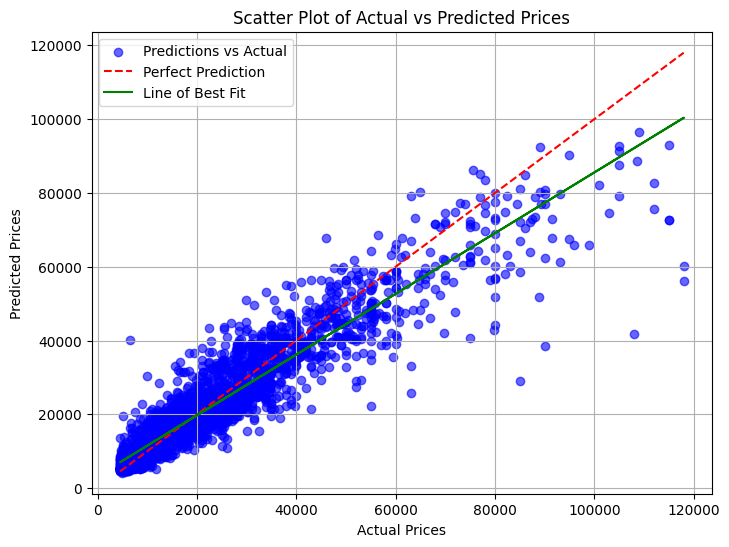

In [ ]:
# Step 3: Initialize and train Decision Tree Regressor
model = GradientBoostingRegressor()
model.fit(X_train, y_train)

# Step 4: Evaluate the model
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # Convert to percentage
median_ae = median_absolute_error(y_test, y_pred)
explained_var = explained_variance_score(y_test, y_pred)

# Display the results
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Median Absolute Error: {median_ae:.2f}")
print(f"Explained Variance Score: {explained_var:.4f}")

plt.figure(figsize=(8, 6))

# Scatter plot: Actual vs Predicted
plt.scatter(y_test, y_pred, alpha=0.6, label='Predictions vs Actual', color='blue')

# Add a reference line for perfect predictions
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')

# Add a line of best fit (regression line)
slope, intercept = np.polyfit(y_test, y_pred, 1)
plt.plot(y_test, slope * y_test + intercept, color='green', label='Line of Best Fit')

# Customize the plot
plt.title('Scatter Plot of Actual vs Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

C:\Users\Burmachach.Nuradilov\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Mean Absolute Error (MAE): 8859.84
Root Mean Squared Error (RMSE): 13760.20
R² Score: 0.2815
Mean Absolute Percentage Error (MAPE): 56.71%
Median Absolute Error: 5922.74
Explained Variance Score: 0.2820


C:\Users\Burmachach.Nuradilov\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


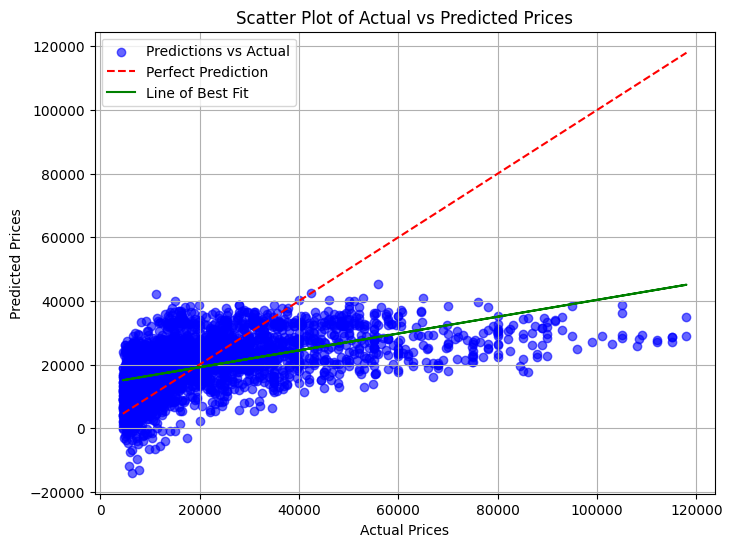

In [100]:
# Step 3: Initialize and train Decision Tree Regressor
model = MLPRegressor(hidden_layer_sizes = 50, alpha = 0.001, solver = 'lbfgs', learning_rate = 'adaptive')
model.fit(X_train, y_train)

# Step 4: Evaluate the model
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # Convert to percentage
median_ae = median_absolute_error(y_test, y_pred)
explained_var = explained_variance_score(y_test, y_pred)

# Display the results
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Median Absolute Error: {median_ae:.2f}")
print(f"Explained Variance Score: {explained_var:.4f}")

plt.figure(figsize=(8, 6))

# Scatter plot: Actual vs Predicted
plt.scatter(y_test, y_pred, alpha=0.6, label='Predictions vs Actual', color='blue')

# Add a reference line for perfect predictions
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')

# Add a line of best fit (regression line)
slope, intercept = np.polyfit(y_test, y_pred, 1)
plt.plot(y_test, slope * y_test + intercept, color='green', label='Line of Best Fit')

# Customize the plot
plt.title('Scatter Plot of Actual vs Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [101]:
df['Condition'].value_counts()

Condition
хорошее                   12581
идеальное                  7098
новое                       905
аварийное / не на ходу       14
Name: count, dtype: int64

In [88]:
data = pd.read_csv('cleaned_data_zakaz_28k.csv')

In [89]:
data.rename(columns={
    "Год выпуска": "Year_of_manufacture",
    "Пробег": "Mileage",
    "Коробка": "Transmission",
    "Климат контроль": "Climate_control",
    "Привод": "Drive_type",
    "Кузов": "Body_type",
    "Руль": "Steering_wheel_position",
    "Состояние": "Condition",
    "Таможня": "Customs_clearance",
    "Регион, город": "Region_city",
    "Учёт": "Registration",
    "Обмен": "Exchange_option",
    "Рассрочка": "Installment_option",
    "получать уведомления": "Receive_notifications",
    "сигнализация": "Alarm_system",
    "автозавод": "Remote_start",
    "кондиционер": "Air_conditioner",
    "климат контроль": "Climate_control",
    "бесключевой доступ": "Keyless_entry",
    "кожа": "Leather_seats",
    "велюр": "Velour_seats",
    "датчик дождя": "Rain_sensor",
    "датчик света": "Light_sensor",
    "бесключевой доступ": "Keyless_entry",
    "бортовой компьютер": "Onboard_computer",
    "парктроник": "Parking_sensors",
    "камера заднего вида": "Rearview_camera",
    "подогрев передних сидений": "Front_seat_heating",
    "память сидений": "Seat_memory",
    "память руля": "Steering_memory",
    "климат контроль": "Climate_control",
    "подогрев передних сидений": "Front_seat_heating",
    "подогрев всех сидений": "All_seat_heating",
    "подогрев задних сидений": "Rear_seat_heating",
    "центральный замок": "Central_locking",
    "налог уплачен": "Tax_paid",
    "корректор фар": "Headlight_adjuster",
    "ксенон": "Xenon_headlights",
    "биксенон": "Bi_xenon_headlights",
    "пневмоподвеска": "Air_suspension",
    "память сидений": "Seat_memory",
    "память руля": "Steering_wheel_memory",
    "корректор фар": "Headlight_adjuster",
    "бесключевой доступ": "Keyless_entry",
    "центральный замок": "Central_locking",
    "подогрев передних сидений": "Front_seat_heating",
    "вентиляция передних сидений": "Front_seat_ventilation",
    "подогрев руля": "Heated_steering_wheel",
    "парктроники": "Parking_sensors",
    "камера заднего вида": "Rearview_camera",
    "литые диски": "Alloy_wheels",
    "велюр": "Velour_seats",
    "кожа": "Leather_seats",
    "парктроник": "Parking_assist",
    "датчик дождя": "Rain_sensor",
    "датчик света": "Light_sensor",
    "парктроник": "Parking_sensors",
    "подогрев руля": "Heated_steering_wheel",
    "климат контроль": "Climate_control",
    "сигнализация": "Alarm_system",
    "автозавод": "Remote_start",
    "центральный замок": "Central_locking",
    "ксенон": "Xenon_headlights",
    "биксенон": "Bi_xenon_headlights",
    "омыватель фар": "Headlight_washer",
    "пневмоподвеска": "Air_suspension",
    "система курсовой устойчивости": "Stability_control",
    "датчик дождя": "Rain_sensor",
    "датчик света": "Light_sensor",
    "бортовой компьютер": "Onboard_computer",
    "центральный замок": "Central_lock",
    "корректор фар": "Headlight_correction",
    "учёт": "Accounting",
    "налог уплачен": "Tax_paid",
    "учет": "Accounting",
    "налог уплачен": "Tax_paid",
    "Марка": "Brand",
    "модель": "Model",
    "restyling": "Restyling",
    "brand": "Brand",
    "model": "Model",
    "Brand_Model_Generation": "Brand_Model_Generation",
    "Days Ago": "Days_Ago",
    "Upped days": "Upped_days",
    "Fuel_type": "Fuel_Type",
    "Volume": "Engine_Volume",
    "Actual Date": "Actual_Date",
    "Price_D": "Price_D",
    "Season": "Season",
    "Month": "Month",
}, inplace=True)


In [90]:
data.head()

Views  Favorites  \
0    375          1   
1    571          0   
2    674         15   
3    318          2   
4    184          0   

                                                                           URL  \
0           https://www.mashina.kg/details/toyota-camry-675cfbec66ae3686218297   
1  https://www.mashina.kg/details/mitsubishi-space-star-67134f11b1d95716775040   
2      https://www.mashina.kg/details/toyota-highlander-67712e832116f708564515   
3           https://www.mashina.kg/details/kia-sportage-67712e60e3c75342153118   
4      https://www.mashina.kg/details/mitsubishi-lancer-67712e4299b88505887872   

   Year_of_manufacture    Mileage          Body_type    Цвет Transmission  \
0                 2022   55000 км              седан  черный      автомат   
1                 2003  380000 км         компактвэн  черный     механика   
2                 2011  250000 км  внедорожник 5 дв.  черный     вариатор   
3                 2019   64373 км  внедорожник 5 дв.   белый      автомат   
4                 2006  212924 км              седан  черный      автомат   

  Drive_type Steering_wheel_position  Condition Customs_clearance    Наличие  \
0   передний                   слева  идеальное        растаможен  в наличии   
1   передний                   слева    хорошее        растаможен  в наличии   
2     полный                   слева  идеальное        растаможен  в наличии   
3     полный                   слева  идеальное        растаможен  в наличии   
4   передний                   слева    хорошее        растаможен  в наличии   

          Region_city       Registration     Exchange_option  \
0              Бишкек         Кыргызстан  рассмотрю варианты   
1              Бишкек         Кыргызстан  рассмотрю варианты   
2              Бишкек         Кыргызстан  рассмотрю варианты   
3              Бишкек         Кыргызстан  рассмотрю варианты   
4  Ош, Ошская область  Не стоит на учёте  рассмотрю варианты   

  Installment_option       Brand       Model  Restyling  \
0                нет      Toyota       Camry       True   
1                нет  Mitsubishi       Space       True   
2                нет      Toyota  Highlander       True   
3                нет         Kia    Sportage       True   
4                нет  Mitsubishi      Lancer       True   

       Brand_Model_Generation  Days_Ago  Upped_days Fuel_Type  Engine_Volume  \
0    Toyota Camry VIII (XV70)        24           9    бензин            3.5   
1     Mitsubishi Space Star I        90           0    бензин            1.6   
2  Toyota Highlander II (U40)        66          66    гибрид            3.5   
3             Kia Sportage IV        66          66    бензин            2.4   
4        Mitsubishi Lancer IX        66          66    бензин            1.6   

           Actual_Date     Month  Season  Price_D  полный электропакет  \
0  2024-12-14 12:32:00  December  Winter    32000                    1   
1  2024-10-09 12:32:00   October  Autumn     4500                    0   
2  2024-11-02 12:33:00  November  Autumn    18500                    1   
3  2024-11-02 12:33:00  November  Autumn    14200                    0   
4  2024-11-02 12:33:00  November  Autumn     4358                    0   

   Alarm_system  Remote_start  Air_conditioner  Climate_control  \
0             1             0                1                1   
1             0             0                0                0   
2             0             0                1                1   
3             0             0                0                0   
4             0             0                0                0   

   газобалонное оборудование  круиз-контроль  Front_seat_heating  \
0                          0               0                   0   
1                          0               0                   0   
2                          0               0                   1   
3                          0               0                   0   
4                 

In [91]:
data['Condition'].value_counts()

Condition
хорошее                   18077
идеальное                  8377
новое                      1494
аварийное / не на ходу      113
Name: count, dtype: int64

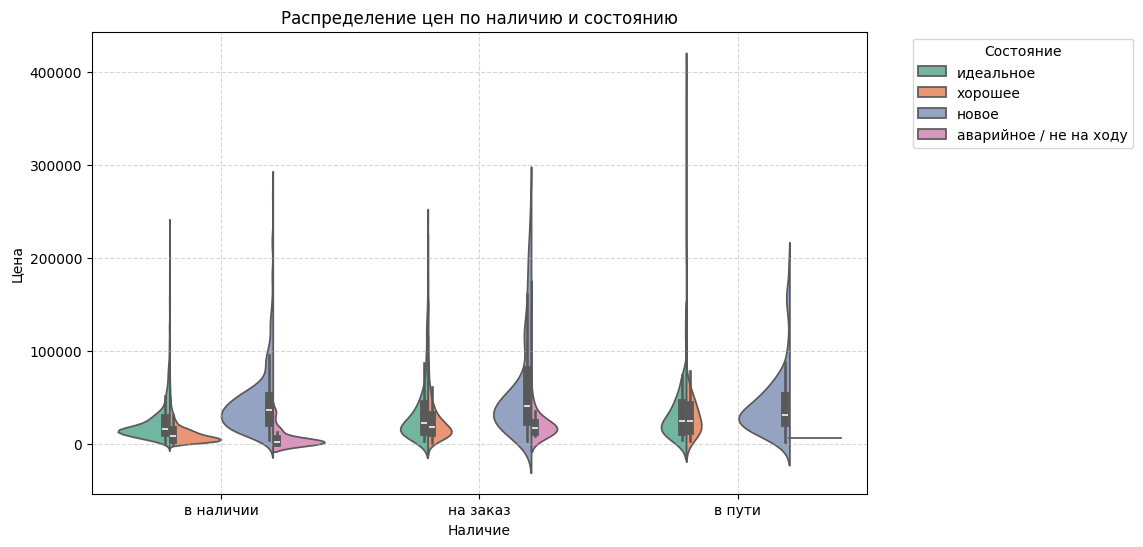

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.violinplot(x=data['Наличие'], y=data['Price_D'], hue=data['Condition'], split=True, palette='Set2')

plt.xlabel("Наличие")
plt.ylabel("Цена")
plt.title("Распределение цен по наличию и состоянию")
plt.legend(title="Состояние", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()


In [93]:
data['Наличие'].value_counts()

Наличие
в наличии    25093
на заказ      2389
в пути         579
Name: count, dtype: int64

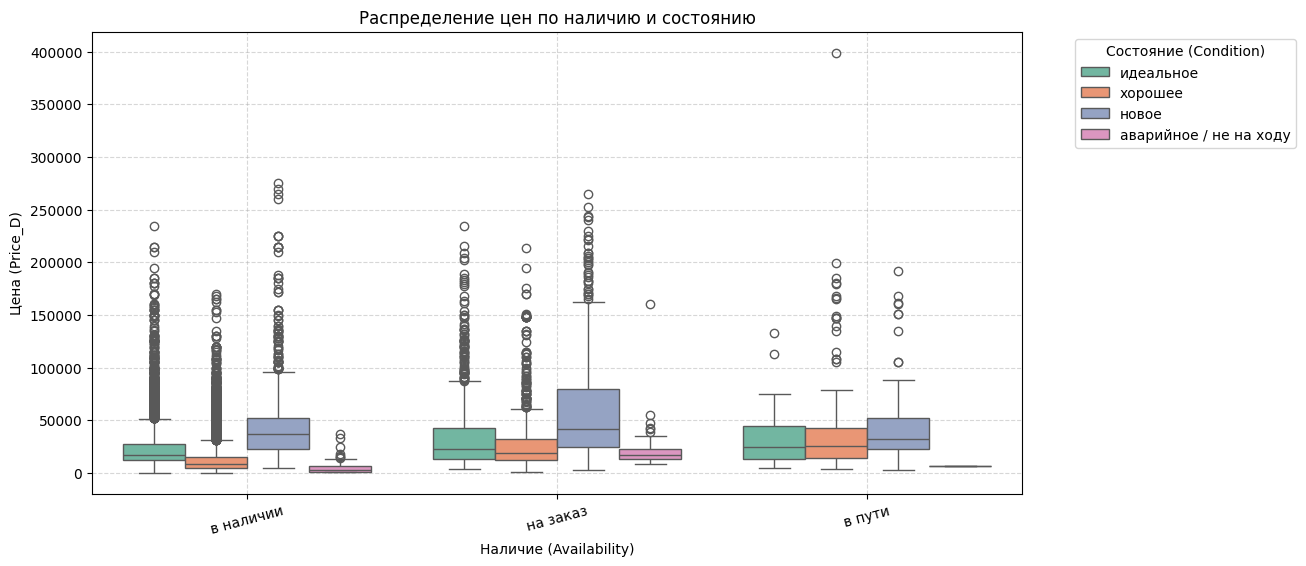

In [94]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Наличие', y='Price_D', hue='Condition', data=data, palette='Set2')

plt.xlabel("Наличие (Availability)")
plt.ylabel("Цена (Price_D)")
plt.title("Распределение цен по наличию и состоянию")
plt.legend(title="Состояние (Condition)", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=15)
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()

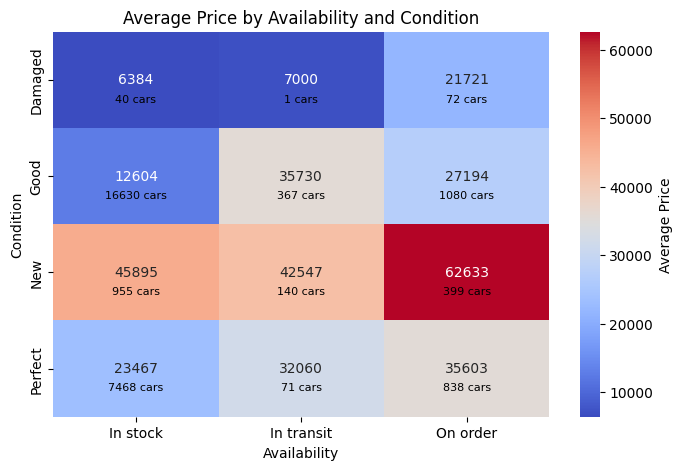

In [95]:
condition_translation = {
    'аварийное / не на ходу': 'Damaged',
    'идеальное': 'Perfect',
    'новое': 'New',
    'хорошее': 'Good'
}

availability_translation = {
    'в наличии': 'In stock',
    'в пути': 'In transit',
    'на заказ': 'On order'
}

# Apply the translation to the 'Condition' and 'Наличие' columns
data['Condition'] = data['Condition'].map(condition_translation)
data['Наличие'] = data['Наличие'].map(availability_translation)
pivot_data = data.pivot_table(index="Condition", columns="Наличие", values="Price_D", aggfunc="mean")

# Calculate the number of cars in each condition and availability combination
car_count = data.groupby(["Condition", "Наличие"]).size().unstack(fill_value=0)

plt.figure(figsize=(8, 5))
sns.heatmap(pivot_data, cmap="coolwarm", annot=True, fmt=".0f", cbar_kws={'label': 'Average Price'})

# Annotating the number of cars slightly offset from the cells
for i in range(pivot_data.shape[0]):
    for j in range(pivot_data.shape[1]):
        plt.text(j+ 0.5, i+ 0.7, f'{car_count.iloc[i, j]:} cars', ha='center', va='center', color='black', fontsize=8)

plt.xlabel("Availability")
plt.ylabel("Condition")
plt.title("Average Price by Availability and Condition")
plt.show()


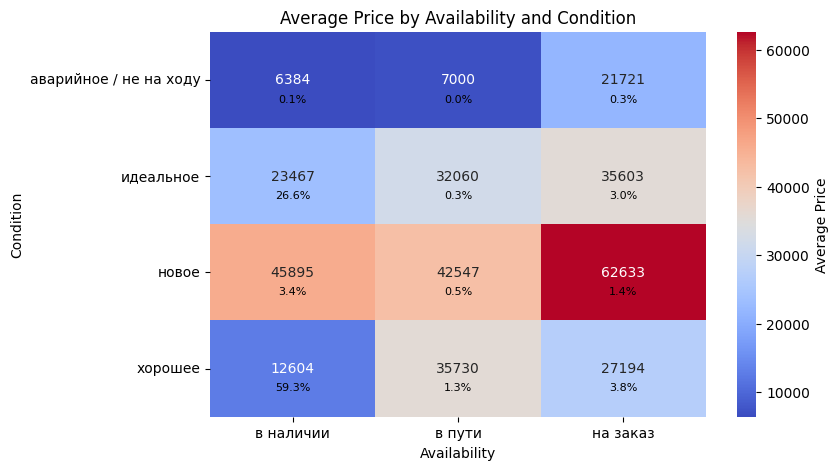

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a pivot table for average price
pivot_data = data.pivot_table(index="Condition", columns="Наличие", values="Price_D", aggfunc="mean")

# Calculate the number of cars in each condition and availability combination
car_count = data.groupby(["Condition", "Наличие"]).size().unstack(fill_value=0)

# Calculate the total number of cars
total_count = car_count.sum().sum()

# Convert car count to percentages
car_percentage = (car_count / total_count) * 100

# Create the heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(pivot_data, cmap="coolwarm", annot=True, fmt=".0f", cbar_kws={'label': 'Average Price'})

# Manually adjust the text position for car percentages to avoid overlap
for i in range(pivot_data.shape[0]):
    for j in range(pivot_data.shape[1]):
        # Move the text position slightly outside the cells
        plt.text(j+ 0.5, i+ 0.7, f'{car_percentage.iloc[i, j]:.1f}%', ha='center', va='center', color='black', fontsize=8)

plt.xlabel("Availability")
plt.ylabel("Condition")
plt.title("Average Price by Availability and Condition")
plt.show()


In [51]:
# Get the current year
from datetime import datetime 
current_year = datetime.now().year

# Calculate the age of the car
data['age'] = current_year - data['Year_of_manufacture']
data['Mileage'] = data['Mileage'].str.extract('(\d+)').astype(int)

# Calculate the average mileage per year
data['average_mileage'] = data.apply(lambda row: row['Mileage'] / row['age'] if row['age'] > 0 else row['Year_of_manufacture'], axis=1)

condition_mapping = {
    "новое": 1,
    "идеальное": 2,
    "хорошее": 3,
    'аварийное / не на ходу':4
}

# Apply the mapping to the 'Condition' column
data['Condition_encoded'] = data['Condition'].map(condition_mapping)
data['Condition_encoded'] = data['Condition_encoded'].astype(int)

data = data[(data['Brand_Model_Generation']!='Mercedes-Benz E-Класс V (W213, S213, C238)') & (data['Price_D']!=8033)]
data = data[(data['Brand_Model_Generation']!='Daewoo Nexia I') & (data['Price_D']!=65000)]

0:	learn: 0.8682334	test: 0.8673953	test1: 0.8411492	best: 0.8411492 (0)	total: 88.6ms	remaining: 1m 28s
100:	learn: 0.2296498	test: 0.2241596	test1: 0.2353911	best: 0.2353907 (99)	total: 9.16s	remaining: 1m 21s
200:	learn: 0.2051924	test: 0.2011804	test1: 0.2192754	best: 0.2192754 (200)	total: 18.3s	remaining: 1m 12s
300:	learn: 0.1892663	test: 0.1870846	test1: 0.2113480	best: 0.2113480 (300)	total: 28.2s	remaining: 1m 5s
400:	learn: 0.1760173	test: 0.1760464	test1: 0.2056843	best: 0.2056614 (399)	total: 38.2s	remaining: 57.1s
500:	learn: 0.1663240	test: 0.1680215	test1: 0.2026709	best: 0.2026656 (499)	total: 48.3s	remaining: 48.1s
600:	learn: 0.1571624	test: 0.1606576	test1: 0.2000146	best: 0.2000146 (600)	total: 58.4s	remaining: 38.7s
700:	learn: 0.1510587	test: 0.1564678	test1: 0.1990360	best: 0.1990246 (697)	total: 1m 8s	remaining: 29.3s
800:	learn: 0.1458679	test: 0.1526875	test1: 0.1979472	best: 0.1979472 (800)	total: 1m 18s	remaining: 19.5s
900:	learn: 0.1418703	test: 0.1499360

C:\Users\Burmachach.Nuradilov\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Burmachach.Nuradilov\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


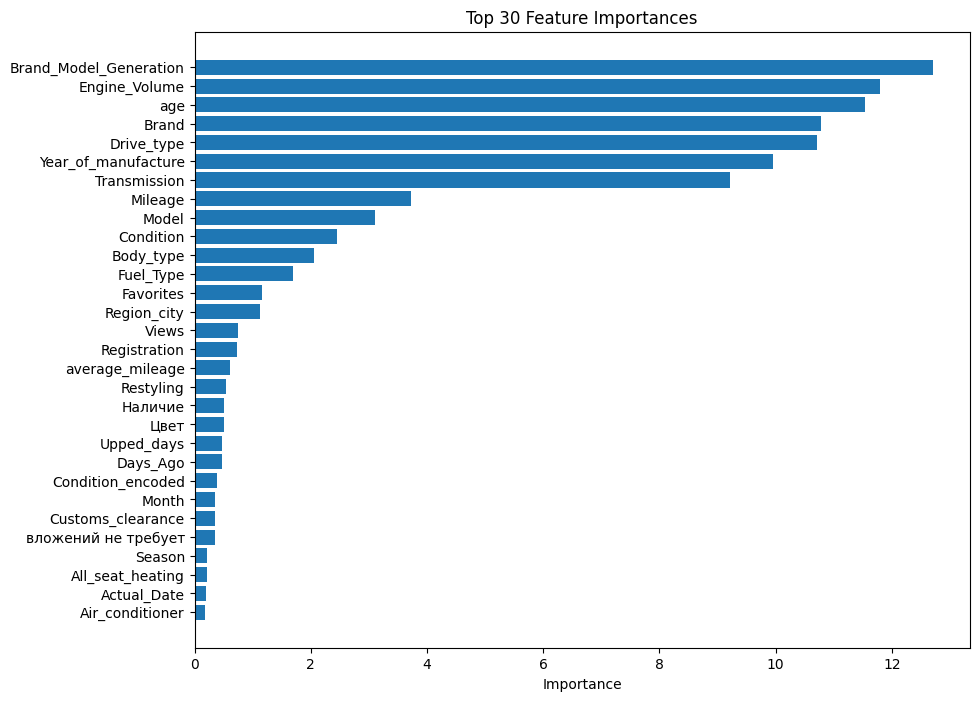

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score, 
    mean_absolute_percentage_error, median_absolute_error, explained_variance_score
)

# Prepare the features and target
X = data.drop(columns=['Price_D'])  # Features
y = data['Price_D']  # Target

# Apply log transformation to the target variable
y_log = np.log1p(y)  # Log transformation (log(x + 1))

# Identify categorical columns by their indices
categorical_columns = [
    X.columns.get_loc(col) 
    for col in X.select_dtypes(include=['object', 'category']).columns
]

# Step 2: Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42  # Use y_log for training
)

# Step 3: Initialize and train CatBoost with categorical features
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=8,
    l2_leaf_reg=10,
    bagging_temperature=0.7944641961311574,
    cat_features=categorical_columns,
    random_seed=42,
    verbose=100,
    border_count=50
)

model.fit(
    X_train, 
    y_train, 
    eval_set=[(X_train, y_train), (X_test, y_test)],  # Track train and test scores
    use_best_model=True,
    early_stopping_rounds=50,
    verbose=100
)

# Predict on training and test sets (log-transformed values)
y_train_pred_log = model.predict(X_train)
y_test_pred_log = model.predict(X_test)

# ❗ Correcting the reverse log transformation ❗
y_train_pred = np.expm1(y_train_pred_log)
y_test_pred = np.expm1(y_test_pred_log)  # FIXED HERE

# Compute metrics for training data
train_mae = mean_absolute_error(np.expm1(y_train), y_train_pred)
train_rmse = mean_squared_error(np.expm1(y_train), y_train_pred, squared=False)
train_r2 = r2_score(np.expm1(y_train), y_train_pred)
train_mape = mean_absolute_percentage_error(np.expm1(y_train), y_train_pred) * 100
train_median_ae = median_absolute_error(np.expm1(y_train), y_train_pred)
train_explained_var = explained_variance_score(np.expm1(y_train), y_train_pred)

# Compute metrics for test data
test_mae = mean_absolute_error(np.expm1(y_test), y_test_pred)
test_rmse = mean_squared_error(np.expm1(y_test), y_test_pred, squared=False)
test_r2 = r2_score(np.expm1(y_test), y_test_pred)
test_mape = mean_absolute_percentage_error(np.expm1(y_test), y_test_pred) * 100
test_median_ae = median_absolute_error(np.expm1(y_test), y_test_pred)
test_explained_var = explained_variance_score(np.expm1(y_test), y_test_pred)

# Display the results
print("\n📌 Model Performance Metrics:\n")
print(f"🔹 Train Data:")
print(f"   - MAE: {train_mae:.2f}")
print(f"   - RMSE: {train_rmse:.2f}")
print(f"   - R² Score: {train_r2:.4f}")
print(f"   - MAPE: {train_mape:.2f}%")
print(f"   - Median Absolute Error: {train_median_ae:.2f}")
print(f"   - Explained Variance Score: {train_explained_var:.4f}\n")

print(f"🔹 Test Data:")
print(f"   - MAE: {test_mae:.2f}")
print(f"   - RMSE: {test_rmse:.2f}")
print(f"   - R² Score: {test_r2:.4f}")
print(f"   - MAPE: {test_mape:.2f}%")
print(f"   - Median Absolute Error: {test_median_ae:.2f}")
print(f"   - Explained Variance Score: {test_explained_var:.4f}")

# Feature Importance Visualization
feature_importances = model.get_feature_importance()
feature_names = X.columns

feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(feat_imp_df['Feature'][:30][::-1], feat_imp_df['Importance'][:30][::-1])
plt.xlabel('Importance')
plt.title('Top 30 Feature Importances')
plt.show()
